# Exploratory Analysis on Cantonese Song Lyrics and Styles of Different Lyricists

## Introduction
This project aims to analyse the styles of different Cantonese lyricsis in terms of their language use in Cantonese songs. In Canontse music (Cantopop) field, lyrics are the most popular element among all. Therefore, even though lyricists are not the performers of the song they are somehow quite well-known and investigated. Given a wide range of Cantopop songs published, it is interesting to know if lyricists are actually different from each other. And if so, in which aspect the differences lie.

## Goal
- to investigate if there are differences among lyricists in terms of syntactic and semantic features (with visualisations)

## Approach
- Lexical Diversity (type / token)
- Syntactic complexity (sentence length) (Limitation: this may be limited by the song melody though.)
- Lexical Density: Proportion of content words. problem: how to define content words for chinese??? 
- Word embedding - in terms of most frequent words and the whole song
- Syntatic bigrams collocations

### Clustering of lyrics - all years
#### TfidfVectorizer
- use tf idf as text vectorizer
- sparse vectors
- bag of words approach
- k-means clustering
ref: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html / https://investigate.ai/text-analysis/using-tf-idf-with-chinese/ 
##### Results
- how many cluster?
- what are the central word (top term) in each cluster? (i.e. the most "influential" words for each cluster)
- Are the songs distinctive enough? Or rather evenly distributed in the space?
- Are there any specific themes that the clusters representing? 
- are the songs mixed throughout the space or concentrated by lyricist?
### Classification of lyrics - by lyricist
- use texts as input and output the class of lyrics -> who write the song?

#### N-gram Analysis
bigram count - countvectorizer and feature extraction from scikitlearn may help?
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

#### analysis - any unique terms used by (a) lyricist(s)?
#### analysis - any unique patterns used by (a) lyricst(s)?
#### analysis - any terms not used by lyricists?
- **Frequency of Collocations**: How often certain bigrams or trigrams appear in the lyrics of different lyricists?
- **Unique Collocations** Any bigrams or trigrams that are unique to a particular lyricist?
- **common collocations** Any collocations that are common across multiple lyricists?

#### dimensionality reduction
https://pages.github.rpi.edu/kuruzj/website_introml_rpi/notebooks/06-unsupervised/01-introduction-pca.html?highlight=pca

In [222]:
import requests
from bs4 import BeautifulSoup
import re
import time

## Pre-processing - Data collection
For this project a music streaming platform KKBOX was used as the database for the lyrics.  
Firstly, playlists from year 2018 to 2023 are sampled from KKBOX. Next, for each song in a playlist, the lyrics, lyricist and some other metadata were fetched and saved in a file.

In [ ]:
playlists_urls = {
    '2018': 'https://www.kkbox.com/hk/tc/playlist/8n1knxmrFBkckchSWf',
    '2019': 'https://www.kkbox.com/hk/tc/playlist/Xa-1BpKeONbo6yeOZ_',
    '2020': 'https://www.kkbox.com/hk/tc/playlist/8nNXPCmrFBkcl9E94A',
    '2021': 'https://www.kkbox.com/hk/tc/playlist/CrUoglVTBQ3cXXp-I1',
    '2022': 'https://www.kkbox.com/hk/tc/playlist/WtihXN25CqR9iAPIBW',
    '2023': 'https://www.kkbox.com/hk/tc/playlist/4ndtnbS42aVxbic-Cg',
    '2023-kkbox': 'https://www.kkbox.com/hk/tc/playlist/0krQef-Uzou3BBCP6T',
    '2022-kkbox': 'https://www.kkbox.com/jp/ja/playlist/0mJEtKQfTW0av5au90',
    '2021-kkbox': 'https://www.kkbox.com/hk/tc/playlist/9-3dm6VIL47LLt2E2K',
}

# save the relevant url links in each year, to access to each lyrics page
def save_urls(year, playlist_url):
    print(f"start saving year {year} with {playlist_url}")
    time.sleep(20)
    response = requests.get(playlist_url, timeout=10)
    html_str = response.content

    document = BeautifulSoup(html_str, "html.parser")
    content_tracks = document.find('div', class_="content-tracks")
    ul_parent = content_tracks.find('ul')

    urls = []

    a_tags = ul_parent.select('li div.song > a')
    for a_tag in a_tags:
        url = a_tag['href']
        print(url)
        urls.append(url)

    filename = year + '-links.txt'
    with open (filename, 'w') as output:
        for url in urls:
            output.write(url)
            output.write('\n')
        print(f"output urls for year {year} complete")

for year, url in playlists_urls.items():
    if year != '2020':
        save_urls(year, url)


In [ ]:
save_urls("2023-kkbox", "https://www.kkbox.com/hk/tc/playlist/0krQef-Uzou3BBCP6T")

In [223]:
"""
a function to retrive the lyrics text, lyricist and other meta data through each link.
"""
def get_lyrics_lyricist_dict(year, url):
    lyrics_dict = {}
    chi_to_eng = {
        '作詞': 'Lyricist',
    }
    lyrics = ""
    response = requests.get(url, timeout=10)
    html_str = response.content
    document = BeautifulSoup(html_str, "html.parser")
    div_title = document.find('div', class_='title')
    print("current title: ", div_title)
    lyrics_dict['title'] = div_title.find('h1').text
    div_lyrics = document.find('div', class_="lyrics")
    
    for p in div_lyrics.find_all('p'):
        p_stripped = (p.text.strip())
        lyrics_components_as_list = p_stripped.split('\n')
        for item in lyrics_components_as_list:
            item = item.strip()
            if '：' in item: # look for some attributes in lyrics (except lyrics texts)
                colon_pos = item.index('：')
                key_chi = item[:colon_pos]
                if key_chi in chi_to_eng:
                    key_eng = chi_to_eng[key_chi]
                    if key_eng not in lyrics_dict:
                        lyrics_dict[key_eng] = item[colon_pos + 1:]
            elif not item.startswith('\xa0'):
                lyrics += item + "\n"
    lyrics_dict['lyrics'] = lyrics
    lyrics_dict['year'] = year
    lyrics_dict['source'] = url
    return lyrics_dict


test = get_lyrics_lyricist_dict('2020', 'https://www.kkbox.com/hk/tc/song/Ok4ByGfXwySdKTSJGp')

current title:  <div class="title">
<h1>無力感</h1>
</div>


In [224]:
import time
import json

"""
a function to scrap lyrics from all the lyrics link for one year file, then save it to a json file
"""
def write_to_one_file(year, filename):
    aggregate_dict = {}
    print("processing year, " , year)
    with open (filename, 'r') as reader:
        urls = reader.readlines()
        for url in urls:
            i = urls.index(url)
            url = url.strip() # get rid of extra white space to ensure the link works
            print("processing: ", i, url)
            try:
                result = get_lyrics_lyricist_dict(year, url)
                aggregate_dict[i] = result
            except Exception as e:
                print("debug error:", e)
            time.sleep(40)
    out_file_name = 'kkbox-urls-dicts/' + year + '-lyrics-fullprofile.json'
    with open(out_file_name, 'w', encoding='utf-8') as output:
        json.dump(aggregate_dict, output, ensure_ascii=False, indent = 4)
    print(f"scrapping {year} complete")


In [ ]:
write_to_one_file("2023-kkbox", 'kkbox-urls-dicts/links/2023-kkbox-links.txt')

In [ ]:
# import os
# import json

# # for item in os.listdir("kkbox-urls-dicts/dicts"):
# #     with open("kkbox-urls-dicts/dicts/"+item) as json_data:
# #         json_dict = json.loads(item)
# #         print(json_dict)

# path = "/Users/kellyyip/Downloads/datascience/kkbox-urls-dicts/dicts/2018-lyrics-fullprofile.json"

# with open(path, 'r') as j:
#      contents = json.loads(j.read())
#      print(contents)

# # filename = "kkbox-urls/2020-links-test.txt"
# # year = filename[filename.index("/")+1:filename.index("/")+5]
# # print(year)

In [176]:
import pandas as pd

### pre-processing - data cleaning
for each song:
1. remove linebreaks
2. check and remove (if needed) duplicated entry
2. remove english lines
4. remove symbols
5. tokenise sentences - with `cantoseg` package

In [38]:
import os
import json

"""
Read the directory and load every json file in the directory into one aggregate pd frame
"""
def aggregate_from_dir_into_dict(directory):
    print("reading " + directory + "...")
    grand_dict = {}
    num_entry = 0
    for item in os.listdir(directory):
        with open(directory+"/"+item, 'r') as json_data:
            print("reading " + item)
            json_dict = json.loads(json_data.read())
            for key, infos in json_dict.items():
                lyrics = infos['lyrics']
                infos['year'] = infos['year'][:4]
                if lyrics.startswith("\n\n"):
                    lyrics = lyrics[2:]
                lyrics_split = lyrics.split("\n")
                lyrics_split_nospace = []
                for line in lyrics_split:
                    line = line.replace(" ", "")
                    lyrics_split_nospace.append(line)
                for line in lyrics_split_nospace:
                    if not len(line) > 0:
                        lyrics_split_nospace.remove(line)
                infos['lyrics'] = lyrics_split_nospace
                grand_dict[num_entry] = infos
                num_entry += 1
    return pd.DataFrame(grand_dict).T

grand_df = aggregate_from_dir_into_dict("kkbox-urls-dicts/dicts")
grand_df


reading kkbox-urls-dicts/dicts...
reading 2021-kkbox-lyrics-fullprofile.json
reading 2020-lyrics-fullprofile.json
reading 2023-lyrics-fullprofile.json
reading 2019-lyrics-fullprofile.json
reading 2021-lyrics-fullprofile.json
reading 2023-kkbox-lyrics-fullprofile.json
reading 2018-lyrics-fullprofile.json
reading 2022-lyrics-fullprofile.json
reading 2022-kkbox-lyrics-fullprofile.json


title Lyricist  \
0           E先生 連環不幸事件      黃偉文   
1      Dear My Friend,      林若寧   
2                不可愛教主      林若寧   
3                  小諧星      黃偉文   
4         Master Class      黃偉文   
..                 ...      ...   
809                二損一       鍾說   
810               生不逢時      林若寧   
811                阿波羅      周耀輝   
812  辣到出汁 (「闔家辣」電影主題曲)      黃偉文   
813               呼吸之間      甄敏延   

                                                lyrics  year  \
0    [連環錯愛, 有誰夠我不幸, 被留在地雷陣覓熱吻, 然而對你我無法太安份, 但求是沒遺憾盡人...  2021   
1    [聽到沒有慶幸當天你在球場邂逅, 雨後哀愁擔當我後援到最後從不講報酬, 單打獨鬥世上只得你未...  2021   
2    [像病態般這麼喜歡你, 你每次接觸都支配悲喜, 眉頭額角聯想都是你無論一起不一起, 寂寞正因...  2021   
3    [跟他沒法比, 他比神完美, 我愛你不起, 早知心碎先將它拆下來擲向地, 將包袱放低, 不追...  2021   
4    [仍多麽的想敬重你吧, 然而一本通書, 你沒有放下, 咸豐的標準, 已落伍吧, 潮流能自創吧...  2021   
..                                                 ...   ...   
809  [Ya~~Haha~Wassup?AyAy~, 請妳好坐低享受夜夜在密謀, 尖叫聲我很需求但...  2022   
810  [願我身體好維持勤勞地上進, 願意卑躬屈膝或許你未動容, 用你的標準掏盡心血亦零作用, 孤獨...  2022   
811  [誰人站在煉獄等一道光, 誰人守於苦海等一個岸, 誰人跪下學習你, 原來學習哀傷痛楚嘆息始終...  2022   
812  [幸運若果更改風向, 獲贈辣椒都可製甜醬這甜醬由挫折釀, 窮極了壞到底就有新氣象, 自問闔家...  2022   
813  [Closeyoureyes, Heyit'sme, 平靜去將呼吸感覺全部放慢, 有多久未歇...  2022   

                                                source  
0    https://www.kkbox.com/hk/tc/song/KkHylzuz5hrtB...  
1    https://www.kkbox.com/hk/tc/song/DXecMcXyg_DL_...  
2    https://www.kkbox.com/hk/tc/song/_Zz_138FncpGN...  
3    https://www.kkbox.com/hk/tc/song/Tai4zelHNCtw9...  
4    https://www.kkbox.com/hk/tc/song/L_fbRys5_NyBr...  
..                                                 ...  
809  https://www.kkbox.com/hk/tc/song/4qIFal28WUFot...  
810  https://www.kkbox.com/hk/tc/song/-nfY9cE4z-Jyg...  
811  https://www.kkbox.com/hk/tc/song/8o-nMH8AlULSB...  
812  https://www.kkbox.com/hk/tc/song/KrqpMicH6Il0D...  
813  https://www.kkbox.com/hk/tc/song/Ol96dHs4S497Y...  

[814 rows x 5 columns]

In [227]:
# pre-processing: remove duplicated songs
grand_df = grand_df.drop_duplicates(subset='title', keep='first')
grand_df = grand_df.reset_index(drop=True) # drop the old index numbers


2. tokenise/ segmenting the lyrics (use the new canto segment? Or jieba? Or pycantonese?)
3. vectorise by scikit learn TfidfVectorizer - for each song?

In [ ]:
########
# testing only
#########

import cantoseg
import zh_core_web_sm

texts = ["連環錯愛", "有誰夠我不幸", "被留在地雷陣覓熱吻"]
texts2 = ["像病態般這麼喜歡你", "你每次接觸都支配悲喜", "眉頭額角聯想都是你無論一起不一起"]
for t in texts2:
    print(cantoseg.cut(t))


In [ ]:
########
# testing only
#########

import spacy
from spacy.tokens import Doc

nlp = spacy.load("zh_core_web_sm")
doc = nlp("眉頭額角聯想都是你無論一起不一起")
tokens = ['眉頭', '額角', '聯想', '都', '是', '你', '無論', '一起', '不', '一起']
# Create a Doc object
# doc = Doc(nlp.vocab, words=tokens)
# for token in doc:
#     print("1", token.text, "2", token.pos_, "3", token.dep_)

# doc = nlp.get_pipe("tagger")(doc)
# doc = nlp.get_pipe("parser")(doc)
for name, proc in nlp.pipeline:
    if name != "tokenizer":
        doc = proc(doc)

for token in doc:
    print(token.text, token.pos_, token.dep_)
# doc_tokens = nlp(tokens)
# for token in doc_tokens:
#     print(token.text, token.pos_, token.dep_)

In [ ]:
########
# testing only
#########

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(tokenizer=cantoseg.cut)
X = count_vectorizer.fit_transform(texts)
X

In [ ]:
########
# testing only
#########

import pandas as pd
X.toarray()
pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names_out())

In [229]:
# remove english occurences
ss = "Hey講一句愛到死"
def clear_english(text):
    if text.isascii():
        return ""
    else:
        new = ""
        for character in text:
            if not character.isascii():
                new += character
        return new

print("original:", ss)
print("cleared:", clear_english(ss))

original: Hey講一句愛到死
cleared: 講一句愛到死


In [230]:
def clear_symbols(text):
    symbols_list = ['（', '）', '~', '～', '！', '!', '?', '？', ',', '，', " ", "\'", "\"", "「", "」", "’", "《", "》", "這首歌曲暫無歌詞歡迎您投稿認養"]
    for character in text:
        if character in symbols_list:
            text = text.replace(character, "")
    return text

text = "Oh~）"
print(clear_symbols(text))


Oh


In [231]:
# pre-process
# remove len 0 string
grand_df['lyrics'] = grand_df['lyrics'].apply(lambda x: [sentence for sentence in x if len(sentence) > 0])

# pre-process
# remove symbols
# remove english words
grand_df['lyrics'] = grand_df['lyrics'].apply(lambda texts : [clear_symbols(text) for text in texts]).apply(lambda texts: [clear_english(text) for text in texts])

grand_df['lyrics']



0      [連環錯愛, 有誰夠我不幸, 被留在地雷陣覓熱吻, 然而對你我無法太安份, 但求是沒遺憾盡人...
1      [聽到沒有慶幸當天你在球場邂逅, 雨後哀愁擔當我後援到最後從不講報酬, 單打獨鬥世上只得你未...
2      [像病態般這麼喜歡你, 你每次接觸都支配悲喜, 眉頭額角聯想都是你無論一起不一起, 寂寞正因...
3      [跟他沒法比, 他比神完美, 我愛你不起, 早知心碎先將它拆下來擲向地, 將包袱放低, 不追...
4      [仍多麽的想敬重你吧, 然而一本通書, 你沒有放下, 咸豐的標準, 已落伍吧, 潮流能自創吧...
                             ...                        
639    [話我沒有深度, 話我大腦爛構造, 麻煩男人天生都很多控訴, 先要挑剔一轉身呷醋, 拋棄他我...
640    [請妳好坐低享受夜夜在密謀, 尖叫聲我很需求但是佢蓋過頭, 那怪誕神經質很討厭, 最錯這宇宙...
641    [願我身體好維持勤勞地上進, 願意卑躬屈膝或許你未動容, 用你的標準掏盡心血亦零作用, 孤獨...
642    [幸運若果更改風向, 獲贈辣椒都可製甜醬這甜醬由挫折釀, 窮極了壞到底就有新氣象, 自問闔家...
643    [平靜去將呼吸感覺全部放慢, 有多久未歇息一晚, 來讓我將不安沖淡, 迷失於世代聚散太多的重...
Name: lyrics, Length: 644, dtype: object

In [233]:
import cantoseg

# tokenise the sentenecs with cantoseg
def tokenize(lyrics):
    tokens_list = []
    for sent in lyrics:
        result = cantoseg.cut(sent)
        tokens_list.append(result)
    return tokens_list

# count the number of characters in each song
def count_character(lyrics):
    count = 0
    for sent in lyrics:
        count += len(sent)
    return count

grand_df['character_count'] = grand_df['lyrics'].apply(count_character)
grand_df['tokenized'] = grand_df['lyrics'].apply(tokenize)
grand_df[['character_count', 'tokenized']]

character_count                                          tokenized
0                405  [[連環, 錯愛], [有, 誰, 夠, 我, 不幸], [被, 留在, 地雷陣, 覓, 熱...
1                394  [[聽到, 沒有, 慶幸, 當天, 你, 在, 球場, 邂逅], [雨後, 哀愁, 擔當, ...
2                251  [[像, 病態, 般, 這麼, 喜歡, 你], [你, 每次, 接觸, 都, 支配, 悲喜]...
3                358  [[跟, 他, 沒法, 比], [他, 比, 神, 完美], [我愛你, 不起], [早知,...
4                392  [[仍, 多, 麽, 的, 想, 敬重, 你, 吧], [然而, 一本, 通書], [你, ...
..               ...                                                ...
639              449  [[話, 我, 沒有, 深度], [話, 我, 大腦, 爛, 構造], [麻煩, 男人, 天...
640              431  [[請, 妳, 好, 坐低, 享受, 夜夜, 在, 密謀], [尖叫聲, 我, 很, 需求,...
641              375  [[願, 我, 身體, 好, 維持, 勤勞, 地, 上進], [願意, 卑躬屈膝, 或許, ...
642              227  [[幸運, 若果, 更改, 風向], [獲贈, 辣椒, 都, 可, 製, 甜醬, 這, 甜醬...
643              324  [[平靜, 去, 將, 呼吸, 感覺, 全部, 放慢], [有, 多久, 未, 歇息, 一晚...

[644 rows x 2 columns]

### tokenized word ratio

This number is calculated by dividing the number of tokens by the original word count in a text. The intuition behind is that with lower TCR, it should reflect more complex compound words or formal structures that consists of multiple characters (polysyllabic words) in the text; on the other hand, higher TCR reflects simpler or more conversational writing because there were more single-character tokens (monosyllabic words).  

For example, "我愛你" ("I love you") and "語言學" (Linguistics) both have three characters, but the TCRs are 1 and 0.3333 respectively, given that the former can be split into 3 separate tokens whereas the latter is one single token.

In [167]:
# compute the tokenized count and "token-chracter" ratio in the lyrics
def count_tcr(lyrics_as_row_item):
    tokenized_count = int(sum(len(sent) for sent in lyrics_as_row_item['tokenized']))
    if lyrics_as_row_item['character_count'] == 0:
        return None
    tcr = tokenized_count / lyrics_as_row_item['character_count']
    return tokenized_count, tcr

count_tcr(grand_df.iloc[0])

grand_df[['tokenized_count', 'tokenized_character_ratio']] = grand_df.apply(count_tcr, axis=1, result_type="expand")

### Lexical diversity
this metric focused on vocabulary richness, that is the variety of vocabulary used in the text. We got the number of unique tokens in a text, and divide the number by the total number of tokens in the text.

In [234]:
def count_lexical_diversity(item):
    flattened_tokens = [token for sent in item['tokenized'] for token in sent]
    tokenized_count = item['tokenized_count']
    if tokenized_count == 0:
        return None
    unique_tokens = set(flattened_tokens)
    result = len(unique_tokens) / tokenized_count
    return result

grand_df['lexical_diversity'] = grand_df.apply(count_lexical_diversity, axis=1)

grand_df[['tokenized_count', 'tokenized_character_ratio', 'lexical_diversity']]


tokenized_count  tokenized_character_ratio  lexical_diversity
0              260.0                   0.641975           0.592308
1              241.0                   0.611675           0.680498
2              166.0                   0.661355           0.542169
3              229.0                   0.639665           0.650655
4              267.0                   0.681122           0.662921
..               ...                        ...                ...
639            304.0                   0.677060           0.582237
640            299.0                   0.693735           0.571906
641            215.0                   0.573333           0.688372
642            156.0                   0.687225           0.698718
643            200.0                   0.617284           0.545000

[644 rows x 3 columns]

In [239]:
# some data pre-process: rename the lyricists
grand_df.loc[grand_df['Lyricist'] == 'Serrini', 'Lyricist'] = '梁嘉茵'
grand_df.loc[grand_df['Lyricist'] == '鐘說', 'Lyricist'] = '鍾說'

# reorder the data-frame
grand_df = grand_df[['title', 'Lyricist', 'year', 'lyrics', 'tokenized', 'character_count', 'tokenized_count', 'tokenized_character_ratio', 'lexical_diversity', 'source']]

A `grand_df_sm` is extracted from the original dataframe for further data aggregation use:

In [235]:
grand_df_sm = grand_df[['title', 'year', 'tokenized_character_ratio', 'lexical_diversity']]
grand_df_sm

title  year  tokenized_character_ratio  lexical_diversity
0            E先生 連環不幸事件  2021                   0.641975           0.592308
1       Dear My Friend,  2021                   0.611675           0.680498
2                 不可愛教主  2021                   0.661355           0.542169
3                   小諧星  2021                   0.639665           0.650655
4          Master Class  2021                   0.681122           0.662921
..                  ...   ...                        ...                ...
639  Little Miss Janice  2022                   0.677060           0.582237
640                 二損一  2022                   0.693735           0.571906
641                生不逢時  2022                   0.573333           0.688372
642   辣到出汁 (「闔家辣」電影主題曲)  2022                   0.687225           0.698718
643                呼吸之間  2022                   0.617284           0.545000

[644 rows x 4 columns]

It was later found out that some song has no data for lyricists or no lyrics at all. Such rows were then dropped.

In [236]:
grand_df_cleaned = grand_df.dropna(subset=['Lyricist'])
grand_df_cleaned = grand_df_cleaned[grand_df_cleaned['lyrics'].apply(lambda x: len(x) > 2)]

In [237]:
grand_df_cleaned

title Lyricist  year  \
0            E先生 連環不幸事件      黃偉文  2021   
1       Dear My Friend,      林若寧  2021   
2                 不可愛教主      林若寧  2021   
3                   小諧星      黃偉文  2021   
4          Master Class      黃偉文  2021   
..                  ...      ...   ...   
639  Little Miss Janice       鍾說  2022   
640                 二損一       鍾說  2022   
641                生不逢時      林若寧  2022   
642   辣到出汁 (「闔家辣」電影主題曲)      黃偉文  2022   
643                呼吸之間      甄敏延  2022   

                                                lyrics  \
0    [連環錯愛, 有誰夠我不幸, 被留在地雷陣覓熱吻, 然而對你我無法太安份, 但求是沒遺憾盡人...   
1    [聽到沒有慶幸當天你在球場邂逅, 雨後哀愁擔當我後援到最後從不講報酬, 單打獨鬥世上只得你未...   
2    [像病態般這麼喜歡你, 你每次接觸都支配悲喜, 眉頭額角聯想都是你無論一起不一起, 寂寞正因...   
3    [跟他沒法比, 他比神完美, 我愛你不起, 早知心碎先將它拆下來擲向地, 將包袱放低, 不追...   
4    [仍多麽的想敬重你吧, 然而一本通書, 你沒有放下, 咸豐的標準, 已落伍吧, 潮流能自創吧...   
..                                                 ...   
639  [話我沒有深度, 話我大腦爛構造, 麻煩男人天生都很多控訴, 先要挑剔一轉身呷醋, 拋棄他我...   
640  [請妳好坐低享受夜夜在密謀, 尖叫聲我很需求但是佢蓋過頭, 那怪誕神經質很討厭, 最錯這宇宙...   
641  [願我身體好維持勤勞地上進, 願意卑躬屈膝或許你未動容, 用你的標準掏盡心血亦零作用, 孤獨...   
642  [幸運若果更改風向, 獲贈辣椒都可製甜醬這甜醬由挫折釀, 窮極了壞到底就有新氣象, 自問闔家...   
643  [平靜去將呼吸感覺全部放慢, 有多久未歇息一晚, 來讓我將不安沖淡, 迷失於世代聚散太多的重...   

                                             tokenized  character_count  \
0    [[連環, 錯愛], [有, 誰, 夠, 我, 不幸], [被, 留在, 地雷陣, 覓, 熱...              405   
1    [[聽到, 沒有, 慶幸, 當天, 你, 在, 球場, 邂逅], [雨後, 哀愁, 擔當, ...              394   
2    [[像, 病態, 般, 這麼, 喜歡, 你], [你, 每次, 接觸, 都, 支配, 悲喜]...              251   
3    [[跟, 他, 沒法, 比], [他, 比, 神, 完美], [我愛你, 不起], [早知,...              358   
4    [[仍, 多, 麽, 的, 想, 敬重, 你, 吧], [然而, 一本, 通書], [你, ...              392   
..                                                 ...              ...   
639  [[話, 我, 沒有, 深度], [話, 我, 大腦, 爛, 構造], [麻煩, 男人, 天...              449   
640  [[請, 妳, 好, 坐低, 享受, 夜夜, 在, 密謀], [尖叫聲, 我, 很, 需求,...              431   
641  [[願, 我, 身體, 好, 維持, 勤勞, 地, 上進], [願意, 卑躬屈膝, 或許, ...              375   
642  [[幸運, 若果, 更改, 風向], [獲贈, 辣椒, 都, 可, 製, 甜醬, 這, 甜醬...              227   
643  [[平靜, 去, 將, 呼吸, 感覺, 全部, 放慢], [有, 多久, 未, 歇息, 一晚...              324   

     tokenized_count  tokenized_character_ratio  lexical_diversity  \
0              260.0                   0.641975           0.592308   
1              241.0                   0.611675           0.680498   
2              166.0                   0.661355           0.542169   
3              229.0                   0.639665           0.650655   
4              267.0                   0.681122           0.662921   
..               ...                        ...                ...   
639            304.0                   0.677060           0.582237   
640            299.0                   0.693735           0.571906   
641            215.0                   0.573333           0.688372   
642            156.0                   0.687225           0.698718   
643            200.0                   0.617284           0.545000   

                                                source  
0    https://www.kkbox.com/hk/tc/song/KkHylzuz5hrtB...  
1    https://www.kkbox.com/hk/tc/song/DXecMcXyg_DL_...  
2    https://www.kkbox.com/hk/tc/song/_Zz_138FncpGN...  
3    https://www.kkbox.com/hk/tc/song/Tai4zelHNCtw9...  
4    https://www.kkbox.com/hk/tc/song/L_fbRys5_NyBr...  
..                                                 ...  
639  https://www.kkbox.com/hk/tc/song/PZzvpYLVfVd6g...  
640  https://www.kkbox.com/hk/tc/song/4qIFal28WUFot...  
641  https://www.kkbox.com/hk/tc/song/-nfY9cE4z-Jyg...  
642  https://www.kkbox.com/hk/tc/song/KrqpMicH6Il0D...  
643  https://www.kkbox.com/hk/tc/song/Ol96dHs4S497Y...  

[644 rows x 10 columns]

# *** saving and loading the (interim) dataframe ***

In [676]:
# save the df in a pickle file
import pickle


with open('grand_df_cleaned.pkl', 'wb') as f:
    pickle.dump(grand_df_cleaned, f)

In [2]:
# # open the df from a pickle file
# a = pd.read_pickle('grand_df_2.pkl')
# a

# Load the cleaned DataFrame from the pickle file
with open('grand_df_cleaned.pkl', 'rb') as f:
    grand_df = pickle.load(f)

grand_df

title Lyricist  year  \
0            E先生 連環不幸事件      黃偉文  2021   
1       Dear My Friend,      林若寧  2021   
2                 不可愛教主      林若寧  2021   
3                   小諧星      黃偉文  2021   
4          Master Class      黃偉文  2021   
..                  ...      ...   ...   
640  Little Miss Janice       鍾說  2022   
641                 二損一       鍾說  2022   
642                生不逢時      林若寧  2022   
643   辣到出汁 (「闔家辣」電影主題曲)      黃偉文  2022   
644                呼吸之間      甄敏延  2022   

                                                lyrics  \
0    [連環錯愛, 有誰夠我不幸, 被留在地雷陣覓熱吻, 然而對你我無法太安份, 但求是沒遺憾盡人...   
1    [聽到沒有慶幸當天你在球場邂逅, 雨後哀愁擔當我後援到最後從不講報酬, 單打獨鬥世上只得你未...   
2    [像病態般這麼喜歡你, 你每次接觸都支配悲喜, 眉頭額角聯想都是你無論一起不一起, 寂寞正因...   
3    [跟他沒法比, 他比神完美, 我愛你不起, 早知心碎先將它拆下來擲向地, 將包袱放低, 不追...   
4    [仍多麽的想敬重你吧, 然而一本通書, 你沒有放下, 咸豐的標準, 已落伍吧, 潮流能自創吧...   
..                                                 ...   
640  [話我沒有深度, 話我大腦爛構造, 麻煩男人天生都很多控訴, 先要挑剔一轉身呷醋, 拋棄他我...   
641  [請妳好坐低享受夜夜在密謀, 尖叫聲我很需求但是佢蓋過頭, 那怪誕神經質很討厭, 最錯這宇宙...   
642  [願我身體好維持勤勞地上進, 願意卑躬屈膝或許你未動容, 用你的標準掏盡心血亦零作用, 孤獨...   
643  [幸運若果更改風向, 獲贈辣椒都可製甜醬這甜醬由挫折釀, 窮極了壞到底就有新氣象, 自問闔家...   
644  [平靜去將呼吸感覺全部放慢, 有多久未歇息一晚, 來讓我將不安沖淡, 迷失於世代聚散太多的重...   

                                             tokenized  character_count  \
0    [[連環, 錯愛], [有, 誰, 夠, 我, 不幸], [被, 留在, 地雷陣, 覓, 熱...              405   
1    [[聽到, 沒有, 慶幸, 當天, 你, 在, 球場, 邂逅], [雨後, 哀愁, 擔當, ...              394   
2    [[像, 病態, 般, 這麼, 喜歡, 你], [你, 每次, 接觸, 都, 支配, 悲喜]...              251   
3    [[跟, 他, 沒法, 比], [他, 比, 神, 完美], [我愛你, 不起], [早知,...              358   
4    [[仍, 多, 麽, 的, 想, 敬重, 你, 吧], [然而, 一本, 通書], [你, ...              392   
..                                                 ...              ...   
640  [[話, 我, 沒有, 深度], [話, 我, 大腦, 爛, 構造], [麻煩, 男人, 天...              449   
641  [[請, 妳, 好, 坐低, 享受, 夜夜, 在, 密謀], [尖叫聲, 我, 很, 需求,...              431   
642  [[願, 我, 身體, 好, 維持, 勤勞, 地, 上進], [願意, 卑躬屈膝, 或許, ...              375   
643  [[幸運, 若果, 更改, 風向], [獲贈, 辣椒, 都, 可, 製, 甜醬, 這, 甜醬...              227   
644  [[平靜, 去, 將, 呼吸, 感覺, 全部, 放慢], [有, 多久, 未, 歇息, 一晚...              324   

     tokenized_count  tokenized_character_ratio  lexical_diversity  \
0              260.0                   0.641975           0.592308   
1              241.0                   0.611675           0.680498   
2              166.0                   0.661355           0.542169   
3              229.0                   0.639665           0.650655   
4              267.0                   0.681122           0.662921   
..               ...                        ...                ...   
640            304.0                   0.677060           0.582237   
641            299.0                   0.693735           0.571906   
642            215.0                   0.573333           0.688372   
643            156.0                   0.687225           0.698718   
644            200.0                   0.617284           0.545000   

                                                source  
0    https://www.kkbox.com/hk/tc/song/KkHylzuz5hrtB...  
1    https://www.kkbox.com/hk/tc/song/DXecMcXyg_DL_...  
2    https://www.kkbox.com/hk/tc/song/_Zz_138FncpGN...  
3    https://www.kkbox.com/hk/tc/song/Tai4zelHNCtw9...  
4    https://www.kkbox.com/hk/tc/song/L_fbRys5_NyBr...  
..                                                 ...  
640  https://www.kkbox.com/hk/tc/song/PZzvpYLVfVd6g...  
641  https://www.kkbox.com/hk/tc/song/4qIFal28WUFot...  
642  https://www.kkbox.com/hk/tc/song/-nfY9cE4z-Jyg...  
643  https://www.kkbox.com/hk/tc/song/KrqpMicH6Il0D...  
644  https://www.kkbox.com/hk/tc/song/Ol96dHs4S497Y...  

[644 rows x 10 columns]

In [161]:
#####################
#
# pre-processing - remove duplicates
#
#####################

# # Convert the list of strings in 'Lyrics' to tuples to make them hashable
# grand_df['Lyrics_Tuple'] = grand_df['lyrics'].apply(tuple)

# # Now use drop_duplicates() based on the tuple version of the lyrics
# grand_df = grand_df.drop_duplicates(subset=['Lyrics_Tuple'], keep='first')

# # Drop the helper 'Lyrics_Tuple' column
# grand_df = grand_df.drop(columns=['Lyrics_Tuple'])

# # Print the result
# grand_df

title Lyricist  year  \
0            E先生 連環不幸事件      黃偉文  2021   
1       Dear My Friend,      林若寧  2021   
2                 不可愛教主      林若寧  2021   
3                   小諧星      黃偉文  2021   
4          Master Class      黃偉文  2021   
..                  ...      ...   ...   
640  Little Miss Janice       鍾說  2022   
641                 二損一       鍾說  2022   
642                生不逢時      林若寧  2022   
643   辣到出汁 (「闔家辣」電影主題曲)      黃偉文  2022   
644                呼吸之間      甄敏延  2022   

                                                lyrics  \
0    [連環錯愛, 有誰夠我不幸, 被留在地雷陣覓熱吻, 然而對你我無法太安份, 但求是沒遺憾盡人...   
1    [聽到沒有慶幸當天你在球場邂逅, 雨後哀愁擔當我後援到最後從不講報酬, 單打獨鬥世上只得你未...   
2    [像病態般這麼喜歡你, 你每次接觸都支配悲喜, 眉頭額角聯想都是你無論一起不一起, 寂寞正因...   
3    [跟他沒法比, 他比神完美, 我愛你不起, 早知心碎先將它拆下來擲向地, 將包袱放低, 不追...   
4    [仍多麽的想敬重你吧, 然而一本通書, 你沒有放下, 咸豐的標準, 已落伍吧, 潮流能自創吧...   
..                                                 ...   
640  [話我沒有深度, 話我大腦爛構造, 麻煩男人天生都很多控訴, 先要挑剔一轉身呷醋, 拋棄他我...   
641  [請妳好坐低享受夜夜在密謀, 尖叫聲我很需求但是佢蓋過頭, 那怪誕神經質很討厭, 最錯這宇宙...   
642  [願我身體好維持勤勞地上進, 願意卑躬屈膝或許你未動容, 用你的標準掏盡心血亦零作用, 孤獨...   
643  [幸運若果更改風向, 獲贈辣椒都可製甜醬這甜醬由挫折釀, 窮極了壞到底就有新氣象, 自問闔家...   
644  [平靜去將呼吸感覺全部放慢, 有多久未歇息一晚, 來讓我將不安沖淡, 迷失於世代聚散太多的重...   

                                             tokenized  character_count  \
0    [[連環, 錯愛], [有, 誰, 夠, 我, 不幸], [被, 留在, 地雷陣, 覓, 熱...              405   
1    [[聽到, 沒有, 慶幸, 當天, 你, 在, 球場, 邂逅], [雨後, 哀愁, 擔當, ...              394   
2    [[像, 病態, 般, 這麼, 喜歡, 你], [你, 每次, 接觸, 都, 支配, 悲喜]...              251   
3    [[跟, 他, 沒法, 比], [他, 比, 神, 完美], [我愛你, 不起], [早知,...              358   
4    [[仍, 多, 麽, 的, 想, 敬重, 你, 吧], [然而, 一本, 通書], [你, ...              392   
..                                                 ...              ...   
640  [[話, 我, 沒有, 深度], [話, 我, 大腦, 爛, 構造], [麻煩, 男人, 天...              449   
641  [[請, 妳, 好, 坐低, 享受, 夜夜, 在, 密謀], [尖叫聲, 我, 很, 需求,...              431   
642  [[願, 我, 身體, 好, 維持, 勤勞, 地, 上進], [願意, 卑躬屈膝, 或許, ...              375   
643  [[幸運, 若果, 更改, 風向], [獲贈, 辣椒, 都, 可, 製, 甜醬, 這, 甜醬...              227   
644  [[平靜, 去, 將, 呼吸, 感覺, 全部, 放慢], [有, 多久, 未, 歇息, 一晚...              324   

     tokenized_count  tokenized_character_ratio  lexical_diversity  \
0              260.0                   0.641975           0.592308   
1              241.0                   0.611675           0.680498   
2              166.0                   0.661355           0.542169   
3              229.0                   0.639665           0.650655   
4              267.0                   0.681122           0.662921   
..               ...                        ...                ...   
640            304.0                   0.677060           0.582237   
641            299.0                   0.693735           0.571906   
642            215.0                   0.573333           0.688372   
643            156.0                   0.687225           0.698718   
644            200.0                   0.617284           0.545000   

                                                source  
0    https://www.kkbox.com/hk/tc/song/KkHylzuz5hrtB...  
1    https://www.kkbox.com/hk/tc/song/DXecMcXyg_DL_...  
2    https://www.kkbox.com/hk/tc/song/_Zz_138FncpGN...  
3    https://www.kkbox.com/hk/tc/song/Tai4zelHNCtw9...  
4    https://www.kkbox.com/hk/tc/song/L_fbRys5_NyBr...  
..                                                 ...  
640  https://www.kkbox.com/hk/tc/song/PZzvpYLVfVd6g...  
641  https://www.kkbox.com/hk/tc/song/4qIFal28WUFot...  
642  https://www.kkbox.com/hk/tc/song/-nfY9cE4z-Jyg...  
643  https://www.kkbox.com/hk/tc/song/KrqpMicH6Il0D...  
644  https://www.kkbox.com/hk/tc/song/Ol96dHs4S497Y...  

[644 rows x 10 columns]

In [162]:
with open('grand_df_cleaned.pkl', 'wb') as f:
    pickle.dump(grand_df, f)

### Who contributed the most?

In Hong Kong pop culture context, three lyricists 黃偉文 (Wyman Wong), 林夕(Lin Xi) and 周耀輝(Chow Yiu Fai) have long been regarded as the "the greatest three lyricists of Cantopop" in recent decades. In particular, Wong has been more active than the other two as reflected by the data. As a side note, Wong has also been awarded the title "Lyricist of the Year" for from 2021 - 2023.

Many "new and potential" lyricists emerged during this decades too. It was no surprise to me that Oscar, 林若寧 (Lam Yuek Ning), 小克 (Siu Hak), 陳詠謙 (Chan Wing Him) came to the top positions, as their names were also very commonly seen in the songs in recent years.

There were a lot more lyricists featured in this dataset, yet lyricists with only one entry are not shown here otherwise it would be too scattered.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


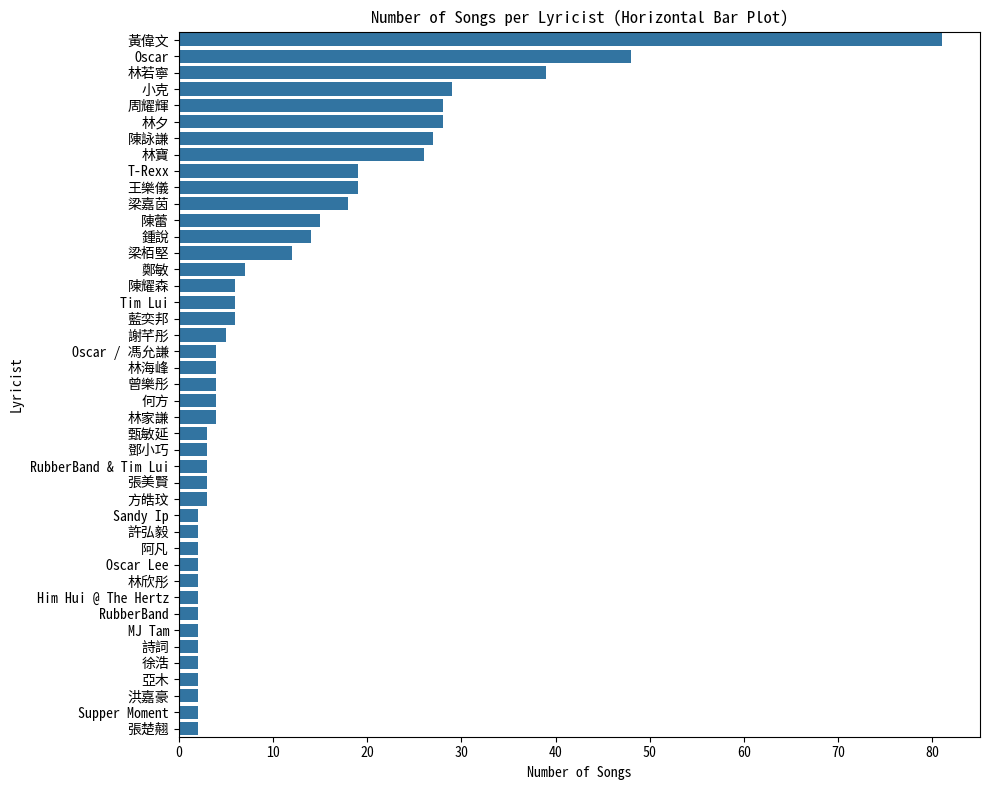

In [174]:
# configure the seaborn font type to enable us to show chinese characters
plt.rcParams['font.sans-serif'] = ['Noto Sans Mono CJK HK']
plt.rcParams['axes.unicode_minus'] = False

lyricist_counts = grand_df['Lyricist'].value_counts()
filtered_lyricist_counts = lyricist_counts[lyricist_counts > 1] # filtered out those who only had one entry

plt.figure(figsize=(10, 8))
sns.barplot(x=filtered_lyricist_counts.values, y=filtered_lyricist_counts.index)
# Add titles and labels
plt.title('Number of Songs per Lyricist (Horizontal Bar Plot)')
plt.xlabel('Number of Songs')
plt.yticks(fontsize=10)
plt.ylabel('Lyricist')
plt.tight_layout()
plt.show()

For clearer comparison, only the top 15 lyricists (in terms of production) would be used from now on.  
In year 2021 there are a significant increase in the number of songs. Looking back in time, 2021 was approximately the time when people said "Cantopop has revived" (a short refernce: https://hongkongfp.com/2021/08/22/mirror-the-boy-band-bringing-joy-and-local-pride-to-hong-kong/)

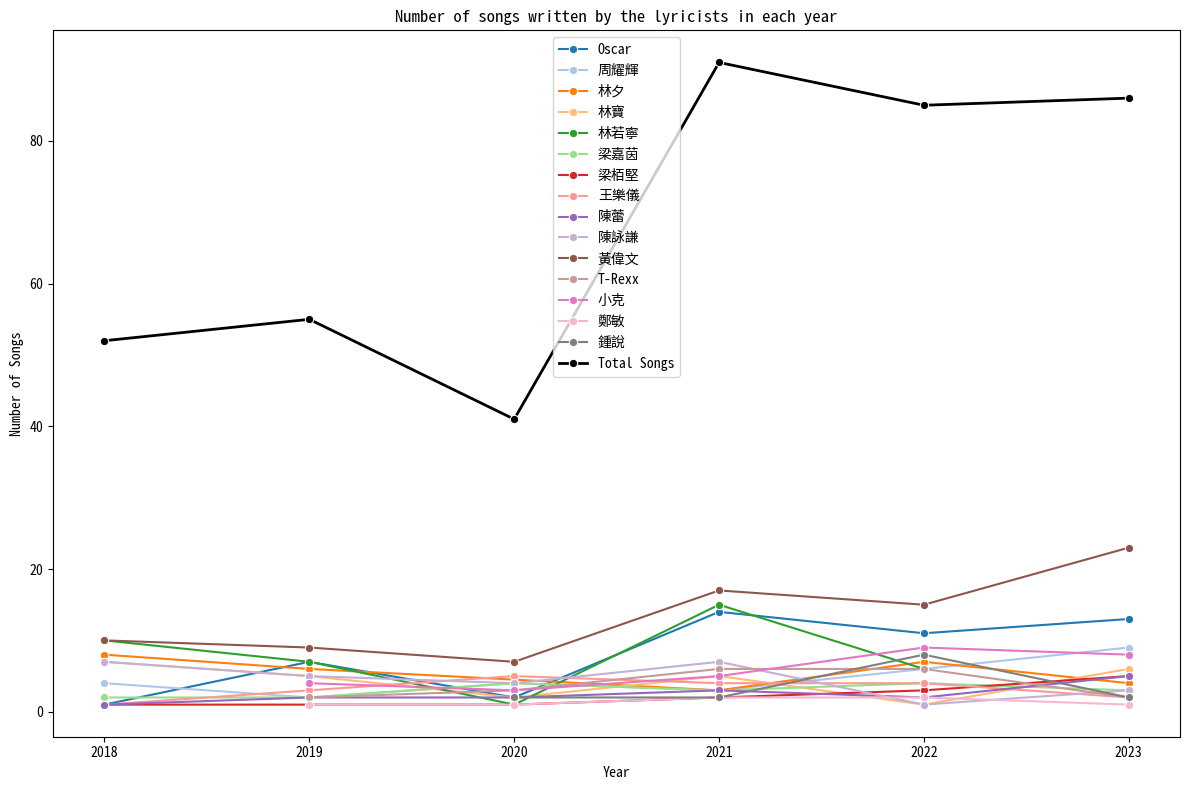

In [165]:
# filter out the df with top 15 frequent lyricists in the corpus
lyricist_counts = grand_df['Lyricist'].value_counts()
top_15 = lyricist_counts.head(15).index
grand_df_in_top15 = grand_df[grand_df['Lyricist'].isin(top_15)]

# statistics over the number of lyrics by different lyricists by years
lyricist_counts_by_year = grand_df_in_top15.groupby(['year', 'Lyricist']).size().reset_index(name='number_of_songs')

# getting total number of songs per year
total_counts_by_year = lyricist_counts_by_year.groupby('year')['number_of_songs'].sum().reset_index(name='total_number_of_songs')

plt.figure(figsize=(12, 8))
# lineplot for each lyricist
sns.lineplot(x='year', y='number_of_songs', hue='Lyricist', data=lyricist_counts_by_year, marker='o', palette=sns.color_palette('tab20', n_colors=15))
# lineplot for each year 
sns.lineplot(x='year', y='total_number_of_songs', data=total_counts_by_year, marker='o', color='black', label='Total Songs', linewidth=2)

plt.title('Number of songs written by the lyricists in each year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')

plt.tight_layout()
plt.show()


### word ratio difference - by lyricist, by year

It was also intereting to see any difference in text complexity across the years and the lyricists in terms of token-character ratio and lexical diversity.

For most lyricists, their TCR was higher than their lexical diversity. In particular, Chow Yiu Fai (周耀輝) has significantly lower lexical diversity than the TCR. 

In [238]:
# !!!! only within the top 15 lyricist !!!!
# Group by year and take the mean 
group_by_lyricist = grand_df_in_top15.groupby('Lyricist')[['tokenized_character_ratio', 'lexical_diversity']].mean()

group_by_year = grand_df_in_top15.groupby('year')[['tokenized_character_ratio', 'lexical_diversity']].mean()

melt_df_lyricists = pd.melt(grand_df_in_top15, id_vars=['Lyricist'], # !!!! only within the top 15 lyricist !!!!
                    value_vars=['tokenized_character_ratio', 'lexical_diversity'], 
                    var_name='metric', value_name='value')

melt_df_year = pd.melt(grand_df, id_vars=['year'],  # retrieve all data back
                    value_vars=['tokenized_character_ratio', 'lexical_diversity'], 
                    var_name='metric', value_name='value')

melt_df_year= melt_df_year.sort_values(by="year")

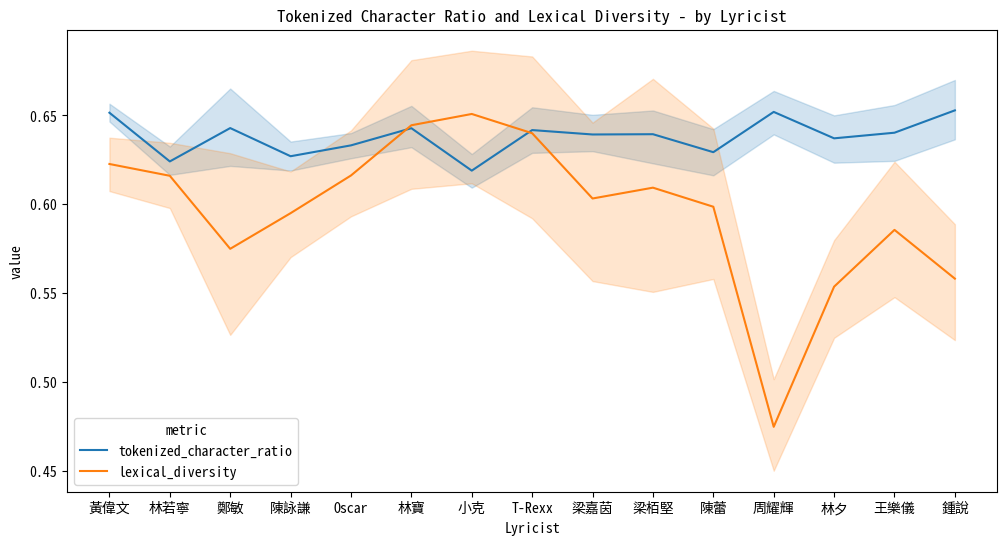

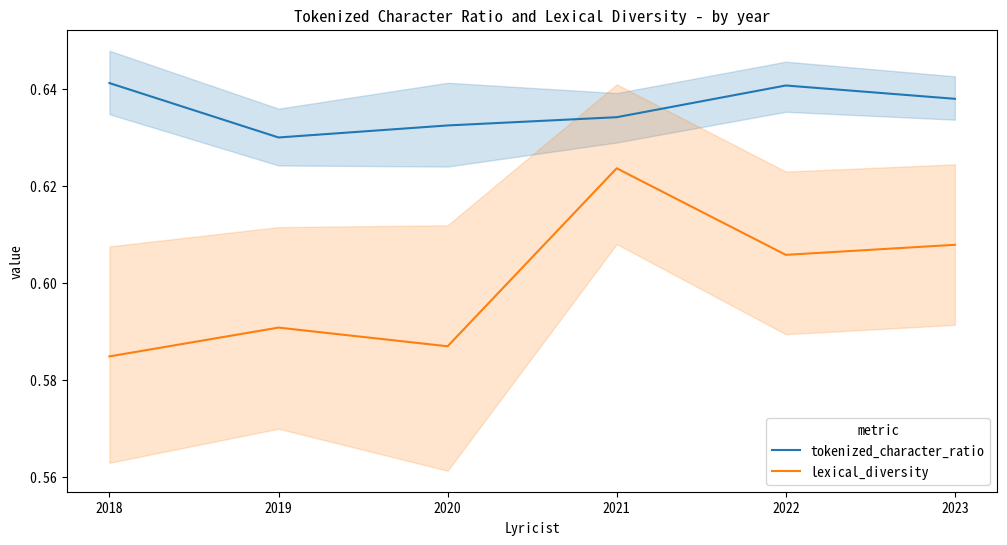

In [167]:
# configure the seaborn font type to enable us to show chinese characters
plt.rcParams['font.sans-serif'] = ['Noto Sans Mono CJK HK']
plt.rcParams['axes.unicode_minus'] = False

# Plot both tokenized character ratio and lexical diversity by Lyricist
plt.figure(figsize=(12, 6))
sns.lineplot(x='Lyricist', y='value', hue='metric', data=melt_df_lyricists)
plt.title('Tokenized Character Ratio and Lexical Diversity - by Lyricist')
plt.xlabel('Lyricist')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='value', hue='metric', data=melt_df_year)
plt.title('Tokenized Character Ratio and Lexical Diversity - by year')
plt.xlabel('Lyricist')
plt.ylabel('value')
plt.show()

### Any relationship between token-character ratio (TCR) and lexical diversity?

Overall speaking, it seemed that the TCR has a slightly negative relationship with lexical diversity. i.e. the more "sophisticated words" are used in a song, the less "diversed" the song is.

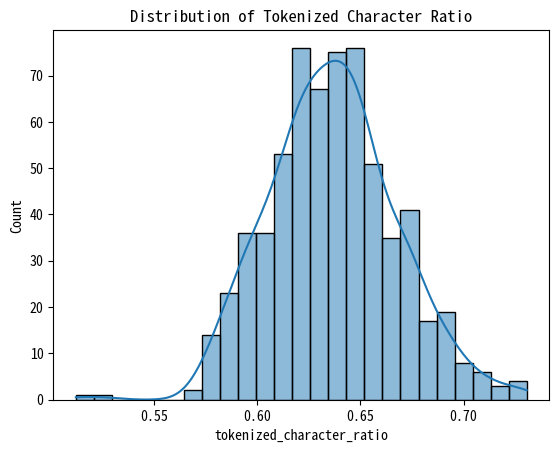

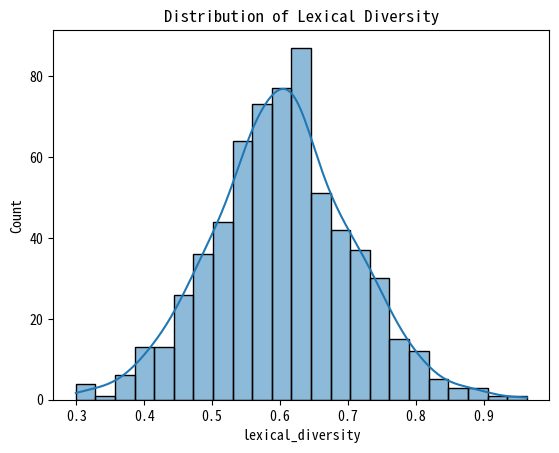

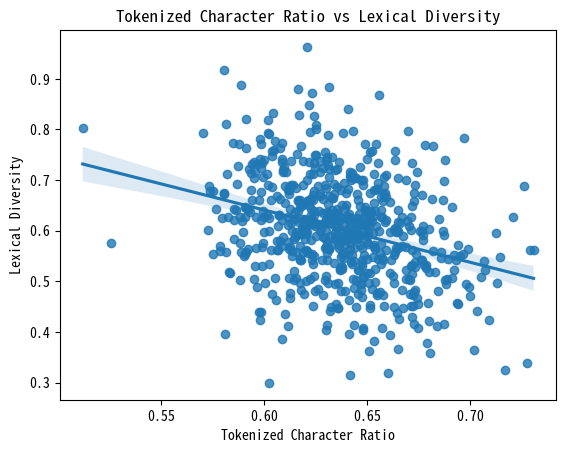

In [168]:
# configure the seaborn font type to enable us to show chinese characters
plt.rcParams['font.sans-serif'] = ['Noto Sans Mono CJK HK']
plt.rcParams['axes.unicode_minus'] = False

# Distribution of Tokenized Character Ratio
sns.histplot(grand_df['tokenized_character_ratio'], kde=True)
plt.title('Distribution of Tokenized Character Ratio')
plt.show()

# Distribution of Lexical Diversity
sns.histplot(grand_df['lexical_diversity'], kde=True)
plt.title('Distribution of Lexical Diversity')
plt.show()

# relationship between tokenized_character_ratio and lexical_diversity
sns.regplot(x='tokenized_character_ratio', y='lexical_diversity', data=grand_df)
plt.title('Tokenized Character Ratio vs Lexical Diversity')
plt.xlabel('Tokenized Character Ratio')
plt.ylabel('Lexical Diversity')
plt.show()

### Which words appeared the most?
#### Pre-processing: a stopword list
a stopword list was manually curated so that we could put focus on words that carries real lexical meanings. The list is not exhaustive but tried to include as many conjunction words and function words that are common in Cantonese. For example, compound words that start with certain prefixes like 前 (front- / pre-) , 後 (after- / post-), and numerals are very often functional words. Also, although single-character morphemes were not necessarily functional words, they were also included in this stopword list for the time being, to better focus on the usage of **compound words**. 

In [4]:
# generate a list of stopwords / function words
def generate_stopwords(tokens_corpus):
    stopwords = ["為何", "可以", "怎麼", "怎樣", "然而", "假如", "除了", "除非", "最後", "終於", "多麼", "多少", "所以", "所有", "即使", "監製", "編曲", "無人", "為了", "因為","尚有", "就是", "就算", "難道", "假如", "必須", "原來", "唯求", "早已", "可能", "全部", "應該", "然後", "當初", "已經", "唯有", "始終"]
    for token_list in tokens_corpus:
        for token_sent in token_list:
            for token in token_sent:
                if len(token) == 1: # bring all monosyllable token to stopwords list
                    if token not in stopwords:
                        stopwords.append(token)
                    continue
                else:
                    # bring all tokens with the following frequent functional prefixes to stopwords list
                    removables = ["一", "不", "這", "那", "沒", "何", "上", "下", "二", "兩", "三", "四", "五", "六", "七", "八", "九", "十", "各", "哪", "我", "你", "他", "之", "也", "太", "前", "後", "仍", "還", "其", "幾", "甚", "什", "更", "有", "以", "自", "要", "繼", "能", "從", "每", "可", "只", "但", "如", "今", "明", "很"]
                    if token[:1] in removables:
                        if token not in stopwords:
                            stopwords.append(token)
                
    return stopwords

stopwords_predefine = generate_stopwords(grand_df['tokenized'])


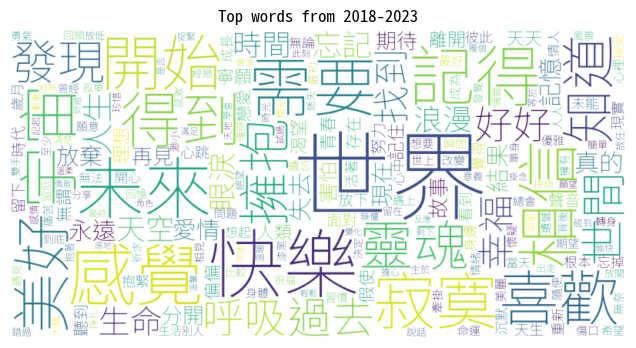

In [169]:
from wordcloud import WordCloud
from collections import Counter

chinese_font_path = "NotoSansHK-VariableFont_wght.ttf"

# grouping all years and generate the grand frequency across years
corpus_all_tokens = [token for song in grand_df['tokenized'] for sent in song for token in sent]
corpus_all_tokens = [token for token in corpus_all_tokens if token not in stopwords_predefine]
corpus_all_tokens_counter = Counter(corpus_all_tokens)

# get the top 10 words from the corpus
top_10_words = corpus_all_tokens_counter.most_common(10)

wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=chinese_font_path).generate_from_frequencies(corpus_all_tokens_counter)

# configure the seaborn font type to enable us to show chinese characters
plt.rcParams['font.sans-serif'] = ['Noto Sans Mono CJK HK']
plt.rcParams['axes.unicode_minus'] = False

# display wordcloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Top words from 2018-2023')
plt.axis('off')
plt.show()



In [170]:
dict(top_10_words)

{'世界': 287,
 '快樂': 158,
 '感覺': 127,
 '未來': 126,
 '記得': 120,
 '需要': 115,
 '相信': 114,
 '寂寞': 106,
 '宇宙': 105,
 '開始': 101}

#### top words in the current database:
count by the total number of occurences in all songs:  
'世界': 287, (world)
 '快樂': 158, (happiness)
 '感覺': 127, (feel)
 '未來': 126, (future)
 '記得': 120, (remember)
 '需要': 115, (need)
 '相信': 114, (believe)
 '寂寞': 106, (alone)
 '宇宙': 105, (universe)
 '開始': 101 (begin)

### analysis of each year:

In [179]:
# aggreagate all tokens into one single list in our corpus
def aggregate_all_tokens(token_column):
    return [token for song in token_column for sent in song for token in sent]


# group the lyrics by YEAR
tokens_by_year = grand_df.groupby('year')['tokenized'] 

# retrieve the tokens in each year 
tokens_by_year = tokens_by_year.apply(aggregate_all_tokens).reset_index()

word_frequency_by_year = {}

for _, row in tokens_by_year.iterrows():
    year = row['year']
    tokens = row['tokenized']
    stopwords = generate_stopwords(grand_df['tokenized'])
    tokens = [token for token in tokens if token not in stopwords]
    token_counter = Counter(tokens)
    word_frequency_by_year[year] = token_counter

most_common_5_by_year = {}
least_common_5_by_year = {}

for year, counter in word_frequency_by_year.items():
    most_common_5_by_year[year] = counter.most_common()[:20]
    least_common_5_by_year[year] = counter.most_common()[-5:]

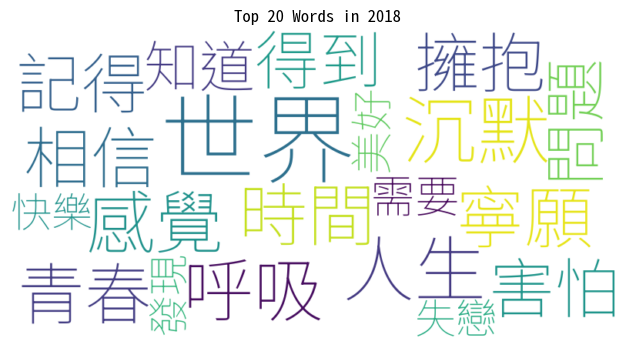

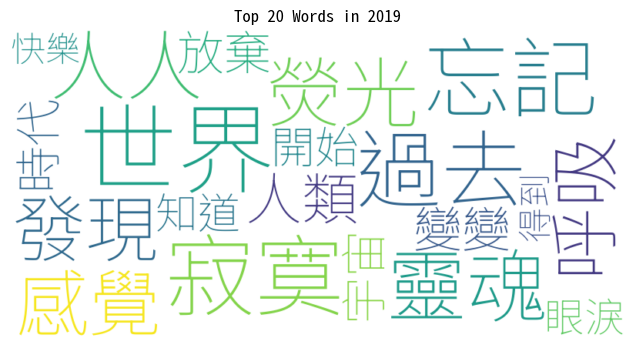

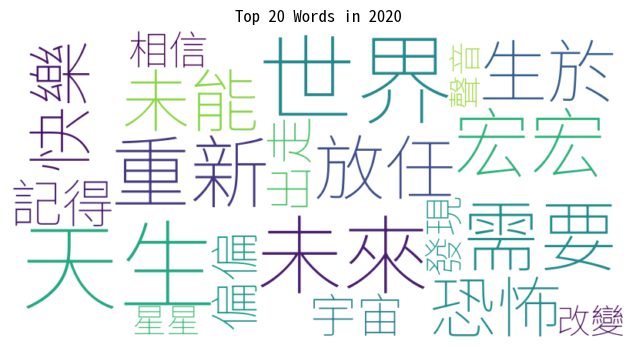

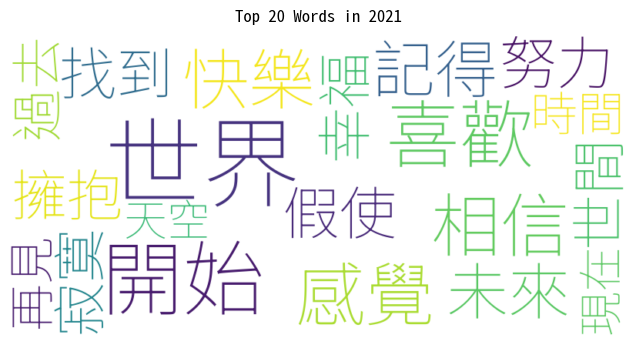

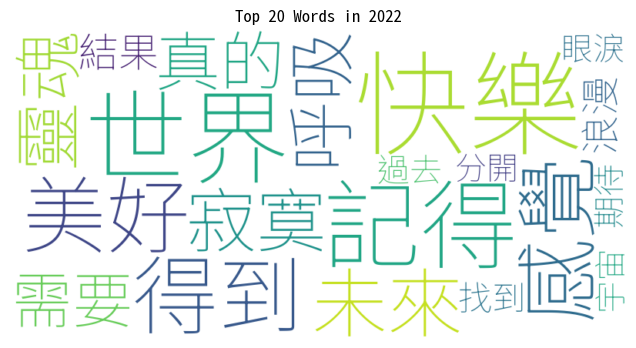

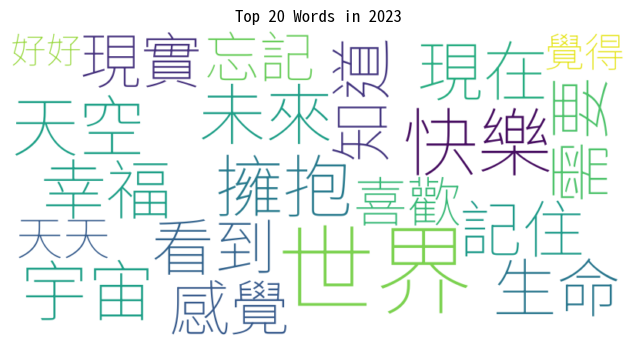

In [172]:
for year, common_words in most_common_5_by_year.items():
    word_freq = dict(common_words)  # Convert list of tuples to dictionary

    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=chinese_font_path).generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Top 20 Words in {year}')
    plt.axis('off')
    plt.show()

In [173]:
# group by "year" + "lyricist"
tokens_groupby_year_lyricist = grand_df_in_top15.groupby(['year', 'Lyricist'])['tokenized'].apply(aggregate_all_tokens).reset_index()

In [180]:
# group by LYRICIST, retrieve the tokenized column
tokens_groupby_lyricist = grand_df_in_top15.groupby('Lyricist')['tokenized'] 
tokens_groupby_lyricist = tokens_groupby_lyricist.apply(aggregate_all_tokens).reset_index()

In [ ]:
# adding counts of songs to the tokenised df for later normalisation
filtered_lyricist_counts_top15_df = filtered_lyricist_counts[:15].reset_index()
df_groupby_lyricist = pd.merge(tokens_groupby_lyricist, filtered_lyricist_counts_top15_df, on='Lyricist', how='left')

For each lyricist, the tokenised words and song counts are extracted into `df_groupby_lyricist`

In [186]:
df_groupby_lyricist

Lyricist                                          tokenized  count_x
0     Oscar  [他, 跟, 她, 都, 講, 率性, 要, 痛快, 透頂, 活著, 為, 放任, 烙, 下...       48
1    T-Rexx  [隨, 視覺, 瞬間, 對望, 打上, 滿, 天花, 火, 而, 脈搏, 迅速, 跳動, 驚...       19
2       周耀輝  [講, 一句, 愛, 到, 死, 講, 多句, 愛, 你, 一世, 不, 相信, 愛會, 死...       28
3        小克  [三更半夜, 迷幻, 音樂, 找, 快樂, 低音, 喇叭, 狂怒, 衝擊, 耳膜, 然後, ...       29
4        林夕  [從前, 常, 在乎, 被, 挽手, 談情, 曾, 但求, 被, 擁有, 彷彿, 從來, 單...       28
5        林寶  [人, 抱著, 一張, 被, 在, 記憶, 棉內, 想起, 你, 枕頭, 從前, 舒適感, ...       26
6       林若寧  [聽到, 沒有, 慶幸, 當天, 你, 在, 球場, 邂逅, 雨後, 哀愁, 擔當, 我, ...       39
7       梁嘉茵  [我, 在, 流, 浮山, 滴, 眼水, 霎眼, 你, 我, 已, 廿, 幾歲, 發覺, 世...       18
8       梁栢堅  [一加, 一加, 一再, 合成, 做注, 碼, 若然, 加多, 一位, 相信, 事情, 就,...       12
9       王樂儀  [天光, 無力, 掉, 眼淚, 不安, 隨著, 鬧市, 聲, 摧毀, 一些, 愛侶, 像, ...       19
10       鄭敏  [為, 你, 我, 做, 春季, 某天, 清早, 的, 細雨, 做, 你, 養分, 醞釀, ...        7
11       鍾說  [我, 叫, 某某, 志氣, 我, 有, 世界, 笑, 我, 醜, 改改, 新, 名, 讓,...       14
12       陳蕾  [曾, 約定, 哪天, 於, 彼此, 婚禮, 中, 你, 穿, 西裝, 獻奏, 我, 穿, ...       15
13      陳詠謙  [就讓, 我, 用, 這, 幾分鐘, 喜歡, 你, 現實, 中, 對, 的, 錯, 的, 不...       27
14      黃偉文  [連環, 錯愛, 有, 誰, 夠, 我, 不幸, 被, 留在, 地雷陣, 覓, 熱吻, 然而...       81

### What are the most and least frequent words used by the lyricists?

In [182]:
# use the tokenised df with lyricist name, tokenised lyrics and number of songs to create frequency dicts

def get_lyricist_frequencies(tokenised_df):
    word_frequency_by_lyricists_counters = {}
    for n, row in tokenised_df.iterrows():
        lyricist_name = tokenised_df.columns.values[0]
        tokenised_column = tokenised_df.columns.values[1]
        num_songs = row[tokenised_df.columns.values[2]]
        print(num_songs)
        print("loading ", row[lyricist_name])
        stopwords = generate_stopwords(grand_df['tokenized'])
        tokenised_list = row[tokenised_column]
        tokenised_list = [token for token in tokenised_list if token not in stopwords]
        token_counter = Counter(tokenised_list)
        token_counter_normalized = {token: count / num_songs for token, count in token_counter.items()}
        token_counter_normalized = sorted(token_counter_normalized.items(), key=lambda x: x[1], reverse=True)
        word_frequency_by_lyricists_counters[row[lyricist_name]] = token_counter_normalized

    return word_frequency_by_lyricists_counters

lyricists_frequencies_dict = get_lyricist_frequencies(tokens_groupby_lyricist)

48
loading  Oscar
19
loading  T-Rexx
28
loading  周耀輝
29
loading  小克
28
loading  林夕
26
loading  林寶
39
loading  林若寧
18
loading  梁嘉茵
12
loading  梁栢堅
19
loading  王樂儀
7
loading  鄭敏
14
loading  鍾說
15
loading  陳蕾
27
loading  陳詠謙
81
loading  黃偉文


In [187]:
lyricists_frequencies_dict

{'Oscar': [('快樂', 0.5416666666666666),
  ('世界', 0.5),
  ('過去', 0.4583333333333333),
  ('好好', 0.375),
  ('擁抱', 0.3333333333333333),
  ('天空', 0.3125),
  ('寂寞', 0.2916666666666667),
  ('恐怖', 0.2916666666666667),
  ('重新', 0.2916666666666667),
  ('痛苦', 0.2708333333333333),
  ('走過', 0.25),
  ('發覺', 0.22916666666666666),
  ('假使', 0.22916666666666666),
  ('剩下', 0.22916666666666666),
  ('忘記', 0.22916666666666666),
  ('害怕', 0.22916666666666666),
  ('記得', 0.22916666666666666),
  ('苦惱', 0.22916666666666666),
  ('生於', 0.22916666666666666),
  ('宇宙', 0.22916666666666666),
  ('心中', 0.22916666666666666),
  ('搞不懂', 0.20833333333333334),
  ('理想', 0.20833333333333334),
  ('青春', 0.20833333333333334),
  ('無法', 0.20833333333333334),
  ('無從', 0.20833333333333334),
  ('轉身', 0.20833333333333334),
  ('靈魂', 0.20833333333333334),
  ('高飛遠走', 0.20833333333333334),
  ('轉動', 0.20833333333333334),
  ('聲音', 0.1875),
  ('密碼', 0.1875),
  ('瑣碎', 0.1875),
  ('望到', 0.1875),
  ('假想', 0.1875),
  ('為著', 0.1875),
  ('祈求', 0.1875

In [247]:
def get_lyricists_most_least_common_dict(lyricist_frequencies_dict):
    most_common_5_dict = {}
    least_common_5_dict = {}
    for lyricist, counter_in_tuples in lyricist_frequencies_dict.items():
        most_common_5_dict[lyricist] = counter_in_tuples[:5]
        least_common_5_dict[lyricist] = counter_in_tuples[-5:]
    return most_common_5_dict, least_common_5_dict


most_common_5_dict, least_common_5_dict = get_lyricists_most_least_common_dict(lyricists_frequencies_dict)
most_common_5_dict

{'Oscar': [('快樂', 0.5416666666666666),
  ('世界', 0.5),
  ('過去', 0.4583333333333333),
  ('好好', 0.375),
  ('擁抱', 0.3333333333333333)],
 'T-Rexx': [('擔心', 0.47368421052631576),
  ('了解', 0.42105263157894735),
  ('逐步', 0.42105263157894735),
  ('感覺', 0.3684210526315789),
  ('經過', 0.3684210526315789)],
 '周耀輝': [('相信', 0.8928571428571429),
  ('未來', 0.75),
  ('天天', 0.6428571428571429),
  ('記住', 0.6428571428571429),
  ('世界', 0.6071428571428571)],
 '小克': [('宇宙', 0.6896551724137931),
  ('手中', 0.5517241379310345),
  ('生命', 0.41379310344827586),
  ('人類', 0.3793103448275862),
  ('世界', 0.3448275862068966)],
 '林夕': [('寂寞', 0.8571428571428571),
  ('世界', 0.4642857142857143),
  ('等於', 0.4642857142857143),
  ('愛情', 0.42857142857142855),
  ('需要', 0.42857142857142855)],
 '林寶': [('世界', 0.5384615384615384),
  ('理由', 0.38461538461538464),
  ('寧願', 0.3076923076923077),
  ('切記', 0.3076923076923077),
  ('最好', 0.3076923076923077)],
 '林若寧': [('愛情', 0.5641025641025641),
  ('喜歡', 0.5384615384615384),
  ('快樂', 0.4871794

To investigate the semantic difference among lyricists, word embedding from spacy model was applied on each of the top five tokens from each lyricist.  
A weighted embedding was also applied according to the relative frequency of the token in the corpus.

In [5]:
import spacy
import numpy as np

# Load a spaCy model with word embeddings (use a Chinese model if needed)
nlp = spacy.load('zh_core_web_md')

/Users/kellyyip/Downloads/datascience/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kellyyip/Downloads/datascience/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/kellyyip/Downloads/datascience/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [248]:
def calculate_weighted_embedding(words_and_freqs, nlp_model):
    weighted_sum = np.zeros(nlp_model.vocab.vectors_length)  # Initialize an empty vector
    total_weight = 0

    for word, normalized_freq in words_and_freqs:
        token = nlp_model(word)
        if token.has_vector:  # Check if the word has an embedding
            weighted_sum += token.vector * normalized_freq  # Multiply embedding by normalized frequency
            total_weight += normalized_freq
    
    # Return the weighted average of embeddings
    if total_weight > 0:
        return weighted_sum / total_weight
    else:
        return np.zeros(nlp_model.vocab.vectors_length)
    

lyricist_embeddings = {}

for lyricist, words_and_freqs in most_common_5_dict.items():
    lyricist_embeddings[lyricist] = calculate_weighted_embedding(words_and_freqs, nlp)


lyricist_embeddings


{'Oscar': array([-3.66197368e-01,  7.54069400e-01,  5.14043313e-01, -1.93051968e+00,
         1.67613603e+00, -7.51351126e-01, -1.08988403e+00, -5.00703412e-01,
        -2.69090685e+00, -7.08759083e-01, -9.53436994e-01,  3.62185501e+00,
        -3.64447765e-01,  1.20494648e+00, -1.26425955e+00,  9.33181070e-02,
         1.68226540e+00, -7.21724750e-01,  2.68512598e-01,  1.49020347e+00,
        -4.20809249e-01, -7.16239065e-01,  1.65753817e+00, -3.28080539e-01,
        -1.75365852e+00, -1.22936780e+00,  1.70318594e+00,  1.27838265e+00,
        -1.49945135e+00,  1.30631930e+00,  4.96271300e-01,  1.68302590e-01,
        -1.70385478e+00, -7.30571718e-01, -2.18751830e+00, -9.78081615e-01,
        -2.04118653e-01, -4.05564912e-01,  2.52190617e-01, -1.09575353e+00,
         7.98507564e-01,  1.64473154e+00,  2.11833203e-01,  1.03922910e+00,
        -8.34532081e-01, -1.37143524e+00,  1.10149056e+00, -1.09485850e+00,
        -2.14348117e+00,  6.48318202e-01, -3.98284354e-01, -2.44991284e+00,
   

In [250]:
# Compare lyricists based on the weighted embeddings
from sklearn.metrics.pairwise import cosine_similarity

def get_lyricists_comparison_by_emb(lyricist_embeddings):
    lyricists = list(lyricist_embeddings.keys())
    num_lyricist = len(lyricists)

    emb_matrix = np.zeros((num_lyricist, num_lyricist))

    for i in range(len(lyricists)):
        for j in range(len(lyricists)):
            embedding_i = lyricist_embeddings[lyricists[i]].reshape(1, -1) # need to reshape to 2D array to calculate cos-sim
            embedding_j = lyricist_embeddings[lyricists[j]].reshape(1, -1)
            cos_similarity = cosine_similarity(embedding_i,embedding_j)[0][0]
            emb_matrix[i, j] = cos_similarity

    cos_similarity_df = pd.DataFrame(emb_matrix, index=lyricists, columns=lyricists)
    
    return cos_similarity_df

emb_similarity_df = get_lyricists_comparison_by_emb(lyricist_embeddings)

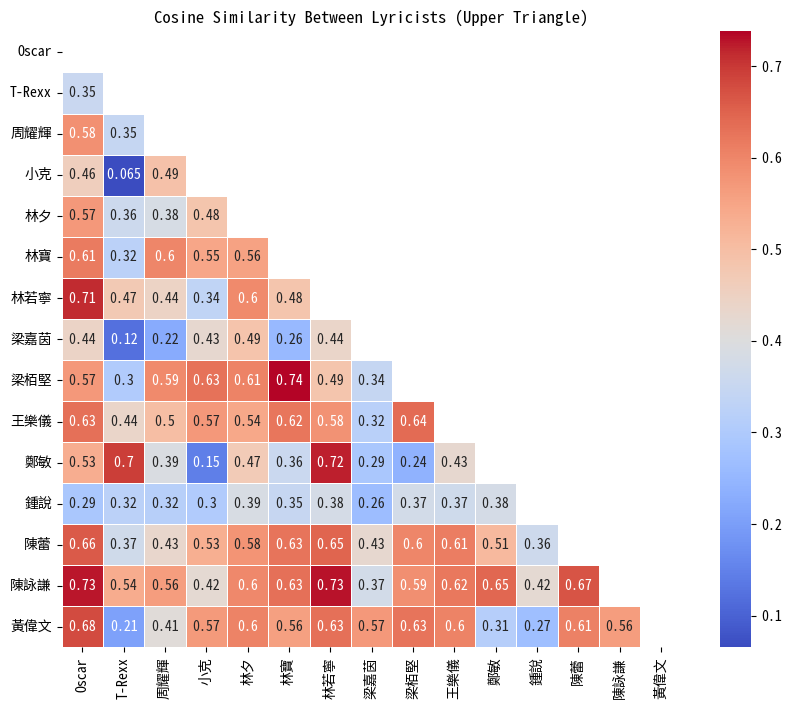

In [182]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(cos_similarity_df, dtype=bool))

# Plot the heatmap, masking the lower triangle
plt.figure(figsize=(10, 8))
sns.heatmap(cos_similarity_df, annot=True, cmap='coolwarm', mask=mask, linewidths=0.5)
plt.title('Cosine Similarity Between Lyricists (Upper Triangle)')
plt.show()

#### Findings from the heatmap
The heatmaps shows and compare the cosine similarities of every lyricists to one another.  
There was a clear blue bar along 鍾說 row (fourth to bottom), suggesting the her average word embedding are less similar to all other lyricists. Vertical blue-ish bars along T-Rexx and 梁嘉茵 were also (eighth to the right) found.
林夕(fifth to the left) seemed to share generally higher similarity with other lyricists.

### Syntactic comparison
#### collocation by n-gram (of tokens, not chracters)

##### Bootstrapping the big corpus first
1. Bigrams of the top terms collocation from top 15 lyricists were extracted. In particular, only Verb-(Pro)Noun, (Pro)Noun-Verb and Adj-Noun were concerned,
2. Them, for each relevant bigram, find out the "term frequency" - in how many songs in the whole corpus does a bigram appear?
3. Compute the "relative frequncy" for each bigram in the whole corpus - how frequent it appears in every 1000 concerned bigrams?
4. Perform bootstrap resampling 1000 times to generate different sets of bigram counts.

##### for each lyricist:
4. Extract the subcorpus corpus for each lyricist
3. Compute the relative frequency same as above
4. Generate a distribution of bigram frequencies for each lyricist across all the bootstrap samples.
5. Compare the confidence intervals of bigram frequencies for the top 10 bigrams across all 15 lyricists to assess any significant differences.


In [6]:
"""
function for POS tagging using spacy pos tagging pipeline - replace the default tokenizer with cantoseg

"""

import spacy
from spacy.tokens import Doc
import cantoseg
# from spacy_curated_transformers.pipeline import TransformerModel

# from spacy.tokens import Doc

def customised_tokenizer_spacy(nlp, text):
    tokenised = cantoseg.cut(text)
    return Doc(nlp.vocab, words=tokenised)

nlp = spacy.load("zh_core_web_md")
nlp.tokenizer = lambda text: customised_tokenizer_spacy(nlp, text)
doc = nlp("雨後哀愁擔當我後援到最後從不講報酬")
print([(w.text, w.pos_) for w in doc])



[('雨後', 'NOUN'), ('哀愁', 'NOUN'), ('擔當', 'VERB'), ('我', 'PRON'), ('後援', 'NOUN'), ('到', 'ADP'), ('最後', 'ADV'), ('從不', 'VERB'), ('講', 'VERB'), ('報酬', 'NOUN')]


In [ ]:
# demo = grand_df_in_top15['lyrics']
# n = 0
# dict_by_POS = {}
# for song in demo:
#     for sent in song:
#         if n < 100: # testing limit
#             sent_doc = nlp(sent)
#             for w in sent_doc:
#                 # print((w.text, w.pos_))
#                 if w.pos_ not in dict_by_POS.keys():
#                     dict_by_POS[w.pos_] = [w.text]
#                 else:
#                     dict_by_POS[w.pos_].append(w.text)
#             n += 1 # testing limit
# dict_by_POS


In [547]:
# # count how many words in each POS

# for pos, wordlist in dict_by_POS.items():
#     keyword = '愛'
#     # if keyword in wordlist:
#     #     print(pos)
#     pos_counter = Counter(wordlist)
#     print(len(wordlist))
#     print(pos)
#     print(pos_counter)

124
NOUN
Counter({'伴': 3, '天空': 3, '孩子': 3, '連環': 2, '命盤': 2, '一欄': 2, '耐性': 2, '夢想': 2, '塵蟎': 2, '當天': 2, '光芒': 2, '人生': 2, '獨處': 2, '地方': 2, '歲月': 2, '輕狂': 2, '世道': 2, '烏托邦': 2, '一千里': 2, '溝通': 2, '白日': 2, '既近': 2, '觸摸': 2, '錯愛': 1, '地雷陣': 1, '良心': 1, '性格': 1, '災禍': 1, '火': 1, '老天': 1, '眼': 1, '大滿貫': 1, '時興': 1, '這款': 1, '蓋棺': 1, '現在': 1, '茶杯': 1, '手牌': 1, '一生': 1, '悲觀': 1, '戀教': 1, '心': 1, '今年': 1, '明年': 1, '誰': 1, '慶幸': 1, '球場': 1, '雨後': 1, '哀愁': 1, '後援': 1, '報酬': 1, '單打獨鬥': 1, '世上': 1, '荒謬': 1, '夏至': 1, '宇宙': 1, '明日': 1, '身旁': 1, '誰肯': 1, '宣洩': 1, '時光': 1, '肩膀': 1, '情緒': 1, '孤獨': 1, '臉': 1, '眼淚': 1, '綠洲': 1, '能源': 1, '孤島': 1, '最光': 1, '星斗': 1, '天空海闊': 1, '現實': 1, '援手': 1, '笑口': 1, '今天': 1, '天堂': 1, '心跳': 1, '活得': 1, '失望': 1, '相約': 1, '風箏': 1, '記憶': 1, '漫天': 1, '星座': 1, '病態': 1, '眉頭': 1, '寂寞': 1, '笑': 1, '但願': 1, '溫馨': 1, '結果': 1, '越感': 1, '吞吐': 1, '神': 1, '我愛你': 1, '心碎': 1, '拆下來': 1})
211
VERB
Counter({'是': 5, '想': 5, '找': 5, '到': 5, '有': 4, '喜歡': 4, '可': 3, '給': 3, '背叛': 3, '需': 

Top 10 words in top 15 lyricists:  
('世界', 197),
 ('快樂', 124),
 ('寂寞', 90),
 ('未來', 90),
 ('喜歡', 85),
 ('宇宙', 84),
 ('記得', 80),
 ('感覺', 79),
 ('美好', 77),
 ('相信', 72)

In [36]:
# grouping all years and generate the grand frequency across years
corpus_all_tokens_in_top15 = [token for song in grand_df_in_top15['tokenized'] for sent in song for token in sent]
corpus_all_tokens_in_top15 = [token for token in corpus_all_tokens_in_top15 if token not in stopwords_predefine]
corpus_all_tokens_counter_in_top15 = Counter(corpus_all_tokens_in_top15)

# get the top 10 words from the corpus
top_10_words_in_top15 = corpus_all_tokens_counter_in_top15.most_common(10)
top_10_words_in_top15

[('世界', 187),
 ('快樂', 123),
 ('寂寞', 90),
 ('未來', 90),
 ('喜歡', 84),
 ('宇宙', 84),
 ('記得', 80),
 ('感覺', 79),
 ('美好', 77),
 ('相信', 72)]

In [ ]:
# load the top 15 df
# with open('grand_df_top15_withspacypos.pkl', 'wb') as f:
#     pickle.dump(grand_df_in_top15, f)

with open('grand_df_top15_withspacypos.pkl', 'rb') as f:
    grand_df_in_top15 = pickle.load(f)

grand_df_in_top15


In [809]:
# return lyrics broken down into tuples of (lemma, pos)

def get_pos(song):
    # for song in corpus:
    song_with_pos = []
    for sent in song:
        sent_doc = nlp(sent)
        token_pos = [(w.text, w.pos_) for w in sent_doc]
        song_with_pos.append(token_pos)
    return song_with_pos

# create a column with POS tag for each token
grand_df_in_top15.loc[:, 'spacy_analysis_pos'] = grand_df_in_top15['lyrics'].apply(get_pos)

In [239]:
grand_df_in_top15['spacy_analysis_pos']

0      [[(連環, NOUN), (錯愛, NOUN)], [(有, VERB), (誰夠, NO...
1      [[(聽到, VERB), (沒有, ADV), (慶幸, NOUN), (當天, NOUN...
2      [[(像, ADP), (病態, NOUN), (般, VERB), (這麼, ADV), ...
3      [[(跟, ADP), (他, PRON), (沒法, ADV), (比, ADP)], [...
4      [[(仍, ADV), (多麽, VERB), (的, PART), (想, VERB), ...
                             ...                        
639    [[(韆鞦, PROPN), (叫, VERB), (你, PRON), (搖撞, VERB...
640    [[(話, INTJ), (我, PRON), (沒有, ADV), (深度, NOUN)]...
641    [[(請妳, NOUN), (好, ADV), (坐, VERB), (低, VERB), ...
642    [[(願, VERB), (我, PRON), (身體, NOUN), (好, ADV), ...
643    [[(幸運, NOUN), (若果, SCONJ), (更, ADV), (改風, VERB...
Name: spacy_analysis_pos, Length: 410, dtype: object

In [241]:
# finding keyword in context

"""
return a list of sentences, broken down into tuples of (lemma, pos, (dep)) in the lyrics that contain the keyword

return: list(tuple)
"""
def get_sentences_with_keyword(keyword, spacy_corpus):
    result = []
    for song in spacy_corpus:
        for sent in song:
            if any(keyword == token_pair[0] for token_pair in sent):
                result.append(sent)
    return result

demo2 = get_sentences_with_keyword("世界", grand_df_in_top15['spacy_analysis_pos'])

demo2

[[('我', 'PRON'),
  ('懶理', 'NOUN'),
  ('這', 'DET'),
  ('世界', 'NOUN'),
  ('悠然自得', 'VERB'),
  ('漂出', 'NOUN'),
  ('海', 'NOUN')],
 [('就', 'ADV'),
  ('合眼', 'VERB'),
  ('設', 'VERB'),
  ('想', 'VERB'),
  ('世界', 'NOUN'),
  ('只得', 'VERB'),
  ('你', 'PRON'),
  ('共', 'ADV'),
  ('我', 'PRON')],
 [('世界', 'NOUN'), ('對話', 'VERB'), ('裡優化', 'ADV')],
 [('重', 'ADV'), ('投入', 'VERB'), ('這', 'DET'), ('世界', 'NOUN'), ('喧鬧', 'NOUN')],
 [('我', 'PRON'),
  ('說', 'NOUN'),
  ('世界', 'NOUN'),
  ('從來', 'ADV'),
  ('沒有', 'VERB'),
  ('天國', 'PROPN')],
 [('洩氣', 'VERB'),
  ('到', 'VERB'),
  ('跳舞', 'VERB'),
  ('我', 'PRON'),
  ('最', 'ADV'),
  ('愛', 'VERB'),
  ('跳舞', 'VERB'),
  ('帶', 'VERB'),
  ('世界', 'NOUN'),
  ('跳兩', 'NOUN'),
  ('步', 'NOUN')],
 [('生於這', 'NOUN'),
  ('世界', 'NOUN'),
  ('還', 'ADV'),
  ('有', 'VERB'),
  ('一些', 'NUM'),
  ('牽掛令', 'NOUN'),
  ('我', 'PRON'),
  ('在乎', 'VERB')],
 [('愛侶', 'NOUN'),
  ('沒有', 'VERB'),
  ('了', 'PART'),
  ('世界', 'NOUN'),
  ('像', 'ADP'),
  ('廢墟', 'NOUN')],
 [('再', 'ADV'), ('說', 'VERB'), ('我', 'PRON'

In [11]:
"""
create a list of ngram-lists which contains tuples(word + pos) 

return: list:list(tuple)
"""
def get_ngram_v2(wordlists, n=3):
    ngram_lists = []
    for wordlist in wordlists:
        ngram_list = []
        for i in range(len(wordlist)-n):
            ngram = wordlist[i:i+n]
            ngram_list.append(ngram)
        ngram_lists.append(ngram_list)
    return ngram_lists

ngram_lists_demo = get_ngram_v2(demo2, n=2)
ngram_lists_demo


[[[('我', 'PRON'), ('懶理', 'NOUN')],
  [('懶理', 'NOUN'), ('這', 'DET')],
  [('這', 'DET'), ('世界', 'NOUN')],
  [('世界', 'NOUN'), ('悠然自得', 'VERB')],
  [('悠然自得', 'VERB'), ('漂出', 'NOUN')]],
 [[('就', 'ADV'), ('合眼', 'VERB')],
  [('合眼', 'VERB'), ('設', 'VERB')],
  [('設', 'VERB'), ('想', 'VERB')],
  [('想', 'VERB'), ('世界', 'NOUN')],
  [('世界', 'NOUN'), ('只得', 'VERB')],
  [('只得', 'VERB'), ('你', 'PRON')],
  [('你', 'PRON'), ('共', 'ADV')]],
 [[('世界', 'NOUN'), ('對話', 'VERB')]],
 [[('重', 'ADV'), ('投入', 'VERB')],
  [('投入', 'VERB'), ('這', 'DET')],
  [('這', 'DET'), ('世界', 'NOUN')]],
 [[('我', 'PRON'), ('說', 'NOUN')],
  [('說', 'NOUN'), ('世界', 'NOUN')],
  [('世界', 'NOUN'), ('從來', 'ADV')],
  [('從來', 'ADV'), ('沒有', 'VERB')]],
 [[('洩氣', 'VERB'), ('到', 'VERB')],
  [('到', 'VERB'), ('跳舞', 'VERB')],
  [('跳舞', 'VERB'), ('我', 'PRON')],
  [('我', 'PRON'), ('最', 'ADV')],
  [('最', 'ADV'), ('愛', 'VERB')],
  [('愛', 'VERB'), ('跳舞', 'VERB')],
  [('跳舞', 'VERB'), ('帶', 'VERB')],
  [('帶', 'VERB'), ('世界', 'NOUN')],
  [('世界', 'NOUN'), ('

In [22]:
"""
return a dictionary counter over the ngrams with the keyword
filter the list of ngram search results by selecting only pairs of VERB-NOUN, NOUN-VERB and ADJ-NOUN bigrams

"""
from collections import Counter

def get_neighbor_context(keyword, ngram_lists):
    matches = ["VERBNOUN", "NOUNVERB", "ADJNOUN", "VERBPRON", "PRONVERB"]
    if ngram_lists == None:
        print("no ngram_list available")
        return None
    
    results = []
    for ngram_list in ngram_lists:
        for ngram in ngram_list:
            for item in ngram:
                if keyword in item:
                    pos_pair = ngram[0][1] + ngram[1][1]
                    if pos_pair in matches:
                        results.append(ngram)
    results_as_tuples = [tuple(result) for result in results]
    results_counter = Counter(results_as_tuples)
    return results_counter
    
    # return results_counter
world_counter = get_neighbor_context("世界", ngram_lists_demo)

world_counter


Counter({(('世界', 'NOUN'), ('有', 'VERB')): 4,
         (('要', 'VERB'), ('世界', 'NOUN')): 3,
         (('世界', 'NOUN'), ('不安', 'VERB')): 3,
         (('叫', 'VERB'), ('世界', 'NOUN')): 2,
         (('不管', 'VERB'), ('世界', 'NOUN')): 2,
         (('讓', 'VERB'), ('世界', 'NOUN')): 2,
         (('將', 'VERB'), ('世界', 'NOUN')): 2,
         (('望見', 'VERB'), ('世界', 'NOUN')): 2,
         (('世界', 'NOUN'), ('散落', 'VERB')): 2,
         (('世界', 'NOUN'), ('快', 'VERB')): 2,
         (('無論', 'VERB'), ('世界', 'NOUN')): 2,
         (('乜鬼', 'VERB'), ('世界', 'NOUN')): 2,
         (('寂寞', 'ADJ'), ('世界', 'NOUN')): 2,
         (('聽', 'VERB'), ('世界', 'NOUN')): 2,
         (('放眼', 'VERB'), ('世界', 'NOUN')): 2,
         (('到', 'VERB'), ('世界', 'NOUN')): 2,
         (('世界', 'NOUN'), ('發現', 'VERB')): 2,
         (('報答', 'VERB'), ('世界', 'NOUN')): 2,
         (('面對', 'VERB'), ('世界', 'NOUN')): 2,
         (('世界', 'NOUN'), ('悠然自得', 'VERB')): 1,
         (('想', 'VERB'), ('世界', 'NOUN')): 1,
         (('世界', 'NOUN'), ('只得', 'VERB')):

In [23]:
# update the count of bigrams in terms of the number of songs the bigram appears
# (not counting by occurrence, to avoid multiple count due to repetition in the same song)
# corpus means grand_df_in_top15['spacy_analysis_pos']
def reduce_count(counter, corpus):
    updated_counter = Counter()
    for bigram in counter:
        for song in corpus:
            for sent in song:
                sent = list(zip(sent, sent[1:]))
                if bigram in sent:
                    # print("add one", bigram, "in", song)
                    updated_counter[bigram] += 1
                    break
    return updated_counter


# corpus means the spacy_analysis_pos column
def count_total_ngrams(corpus, n=2):
    total_ngrams = 0
    for song in corpus:
        for sent in song:
            num_ngrams = max(0, len(sent) - (n-1))
            total_ngrams += num_ngrams
    return total_ngrams

reduce_count(world_counter, grand_df_in_top15['spacy_analysis_pos'])


Counter({(('叫', 'VERB'), ('世界', 'NOUN')): 2,
         (('世界', 'NOUN'), ('有', 'VERB')): 2,
         (('世界', 'NOUN'), ('大變', 'VERB')): 2,
         (('世界', 'NOUN'), ('快', 'VERB')): 2,
         (('聽', 'VERB'), ('世界', 'NOUN')): 2,
         (('到', 'VERB'), ('世界', 'NOUN')): 2,
         (('世界', 'NOUN'), ('悠然自得', 'VERB')): 1,
         (('想', 'VERB'), ('世界', 'NOUN')): 1,
         (('世界', 'NOUN'), ('只得', 'VERB')): 1,
         (('世界', 'NOUN'), ('對話', 'VERB')): 1,
         (('帶', 'VERB'), ('世界', 'NOUN')): 1,
         (('發現', 'VERB'), ('世界', 'NOUN')): 1,
         (('出新', 'VERB'), ('世界', 'NOUN')): 1,
         (('殘破', 'ADJ'), ('世界', 'NOUN')): 1,
         (('世界', 'NOUN'), ('令', 'VERB')): 1,
         (('不管', 'VERB'), ('世界', 'NOUN')): 1,
         (('讓', 'VERB'), ('世界', 'NOUN')): 1,
         (('過搏', 'VERB'), ('世界', 'NOUN')): 1,
         (('將', 'VERB'), ('世界', 'NOUN')): 1,
         (('世界', 'NOUN'), ('笑', 'VERB')): 1,
         (('實', 'ADJ'), ('世界', 'NOUN')): 1,
         (('世界', 'NOUN'), ('沒有', 'VERB')): 1,


In [30]:
# corpus means ''spacy_analysis_pos''
def get_all_collocation_counts(corpus):
    all_counts = Counter()
    matches = ['VERBNOUN', 'NOUNVERB', 'ADJNOUN', 'PRONVERB', 'VERBPRON']
    for song in corpus:
        collocation_set = set()
        for sent in song:
            if len(sent) > 1:
                sent = list(zip(sent, sent[1:]))
                for item in sent:
                    pair = item[0][1] + item[1][1]
                    if pair in matches:
                        collocation_set.add(item)
        all_counts.update(collocation_set)
    return all_counts

all_collocation_counts = get_all_collocation_counts(grand_df_in_top15['spacy_analysis_pos'])


In [31]:
all_collocation_counts.total()

12390

In [242]:
# initialise a dictionary storing the bigram and its count for each "top token"
def get_dict_frequent_word(topwords):
    result = {}
    for word in topwords:
        result[word[0]] = {}
    return result

dict_frequent_keyword_collocations = get_dict_frequent_word(top_10_words_in_top15)
dict_frequent_keyword_collocations

{'世界': {},
 '快樂': {},
 '寂寞': {},
 '未來': {},
 '喜歡': {},
 '宇宙': {},
 '記得': {},
 '感覺': {},
 '美好': {},
 '相信': {}}

In [66]:
# corpus = grand_df_in_top15['spacy_analysis_pos']
def get_aggregate_collocations_ratios(corpus, dict_keywords_collocation_count, total_counts):
    for keyword, keyword_collocation_counter in dict_keywords_collocation_count.items():
            search_results = get_sentences_with_keyword(keyword, corpus)
            bigram_lists = get_ngram_v2(search_results, n=2)
            bigrams_counter = get_neighbor_context(keyword, bigram_lists)
            reduced_counter = reduce_count(bigrams_counter, corpus)
            for ngram, count in reduced_counter.items():
                    ratio = (count / total_counts) * 1000
                    if ngram in keyword_collocation_counter:
                        keyword_collocation_counter[ngram].append(ratio)
                    else:
                        keyword_collocation_counter[ngram] = [ratio]
    return dict_keywords_collocation_count

# original_aggregate_data_pmi = 
original_aggregate_data_ratio = get_aggregate_collocations_ratios(grand_df_in_top15['spacy_analysis_pos'], dict_frequent_keyword_collocations, all_collocation_counts.total())

In [67]:
original_aggregate_data_ratio

{'世界': {(('世界', 'NOUN'), ('悠然自得', 'VERB')): [0.08071025020177564],
  (('想', 'VERB'), ('世界', 'NOUN')): [0.08071025020177564],
  (('世界', 'NOUN'), ('只得', 'VERB')): [0.08071025020177564],
  (('世界', 'NOUN'), ('對話', 'VERB')): [0.08071025020177564],
  (('帶', 'VERB'), ('世界', 'NOUN')): [0.08071025020177564],
  (('發現', 'VERB'), ('世界', 'NOUN')): [0.08071025020177564],
  (('出新', 'VERB'), ('世界', 'NOUN')): [0.08071025020177564],
  (('叫', 'VERB'), ('世界', 'NOUN')): [0.16142050040355127],
  (('殘破', 'ADJ'), ('世界', 'NOUN')): [0.08071025020177564],
  (('世界', 'NOUN'), ('令', 'VERB')): [0.08071025020177564],
  (('不管', 'VERB'), ('世界', 'NOUN')): [0.08071025020177564],
  (('讓', 'VERB'), ('世界', 'NOUN')): [0.08071025020177564],
  (('過搏', 'VERB'), ('世界', 'NOUN')): [0.08071025020177564],
  (('將', 'VERB'), ('世界', 'NOUN')): [0.08071025020177564],
  (('世界', 'NOUN'), ('笑', 'VERB')): [0.08071025020177564],
  (('實', 'ADJ'), ('世界', 'NOUN')): [0.08071025020177564],
  (('世界', 'NOUN'), ('沒有', 'VERB')): [0.08071025020177564],

In [ ]:
def bootstrap_get_ratio_aggregate(corpus, n=1000):
    dict_frequent_keyword_collocations_ratio = get_dict_frequent_word(top_10_words_in_top15)
    for i in range(n):
        print("iteration", i)
        bootstrap_df = corpus.sample(n=len(corpus), replace=True)
        all_collocation_counts = get_all_collocation_counts(bootstrap_df['spacy_analysis_pos'])
        dict_frequent_keyword_collocations_ratio = get_aggregate_collocations_ratios(bootstrap_df['spacy_analysis_pos'], dict_frequent_keyword_collocations_ratio, all_collocation_counts.total())
    return dict_frequent_keyword_collocations_ratio

# the dictionary storing all bigrams counts distribution (bigram freq in 1000 words) 
bootstrap_ratio_aggregate = bootstrap_get_ratio_aggregate(grand_df_in_top15, n=1000)

In [243]:
bootstrap_ratio_aggregate

{'世界': {(('面對', 'VERB'), ('世界', 'NOUN')): [0.1590583744234134,
   0.16335865392469165,
   0.159821000479463,
   0.08043111075363951,
   0.16287971333170453,
   0.08216251745953496,
   0.16029494269455796,
   0.1620482903905364,
   0.15704750687082844,
   0.07788161993769471,
   0.32396533570907915,
   0.08062565508344754,
   0.0827335153470671,
   0.08195377806916898,
   0.08116224332440548,
   0.16474464579901152,
   0.16258840744654907,
   0.08301510874979245,
   0.23798191337458352,
   0.08082114281095935,
   0.07956715467854869,
   0.08196721311475409,
   0.08031483414986748,
   0.0828775070445881,
   0.08181966944853543,
   0.1631986944104447,
   0.08237232289950576,
   0.0827129859387924,
   0.08053475074494644,
   0.08161932745674176,
   0.08254230293025175,
   0.32149172158816913,
   0.07951653944020357,
   0.08087343307723413,
   0.0795291872117067,
   0.07958615200955034,
   0.07974481658692185,
   0.24263992235522483,
   0.1607200257152041,
   0.08238589553468446,
   0.15885

In [244]:
# Save the data to a file
with open('bootstrap_ratio_aggregate.pkl', 'wb') as f:
    pickle.dump(bootstrap_ratio_aggregate, f)

In [73]:
def save_lyricist_data(file, filename):
    path = filename + ".pkl"
    with open(path, 'wb') as f:
        pickle.dump(file, f)
    print("saved", path)

In [82]:
# get the DataFrame filtered with the lyricist name
for lyricist in set(grand_df_in_top15['Lyricist']):
        print("loading", lyricist)
        original_filename = lyricist + "_collocation_ratio"
        df_lyricist = grand_df_in_top15[grand_df_in_top15['Lyricist'] == lyricist]
        individual_dict_frequent_word_ngram = get_dict_frequent_word(top_10_words_in_top15)
        all_collocation_counts = get_all_collocation_counts(df_lyricist['spacy_analysis_pos'])
        individual_dict_frequent_word_ngram = get_aggregate_collocations_ratios(df_lyricist['spacy_analysis_pos'], individual_dict_frequent_word_ngram, all_collocation_counts.total())
        save_lyricist_data(individual_dict_frequent_word_ngram, original_filename)

loading 黃偉文
saved 黃偉文_collocation_ratio.pkl
loading 林寶
saved 林寶_collocation_ratio.pkl
loading 小克
saved 小克_collocation_ratio.pkl
loading 梁嘉茵
saved 梁嘉茵_collocation_ratio.pkl
loading 陳蕾
saved 陳蕾_collocation_ratio.pkl
loading Oscar
saved Oscar_collocation_ratio.pkl
loading 鍾說
saved 鍾說_collocation_ratio.pkl
loading T-Rexx
saved T-Rexx_collocation_ratio.pkl
loading 陳詠謙
saved 陳詠謙_collocation_ratio.pkl
loading 林夕
saved 林夕_collocation_ratio.pkl
loading 林若寧
saved 林若寧_collocation_ratio.pkl
loading 梁栢堅
saved 梁栢堅_collocation_ratio.pkl
loading 鄭敏
saved 鄭敏_collocation_ratio.pkl
loading 王樂儀
saved 王樂儀_collocation_ratio.pkl
loading 周耀輝
saved 周耀輝_collocation_ratio.pkl


In [83]:
# sample from the df to get the new corpus
# bootstrap_df_1 = grand_df_in_top15.sample(n=len(grand_df_in_top15), replace=True)

with open('黃偉文_collocation_ratio.pkl', 'rb') as f:
    testdf = pickle.load(f)

testdf

{'世界': {(('世界', 'NOUN'), ('對話', 'VERB')): [0.3938558487593541],
  (('殘破', 'ADJ'), ('世界', 'NOUN')): [0.3938558487593541],
  (('世界', 'NOUN'), ('令', 'VERB')): [0.3938558487593541],
  (('過搏', 'VERB'), ('世界', 'NOUN')): [0.3938558487593541],
  (('囂給', 'VERB'), ('世界', 'NOUN')): [0.3938558487593541],
  (('世界', 'NOUN'), ('跌入', 'VERB')): [0.3938558487593541],
  (('到', 'VERB'), ('世界', 'NOUN')): [0.3938558487593541],
  (('出生', 'VERB'), ('世界', 'NOUN')): [0.3938558487593541]},
 '快樂': {(('見', 'VERB'), ('快樂', 'NOUN')): [0.3938558487593541],
  (('快樂', 'NOUN'), ('是', 'VERB')): [0.3938558487593541],
  (('快樂', 'VERB'), ('我', 'PRON')): [0.7877116975187082]},
 '寂寞': {(('寂寞', 'ADJ'), ('望真', 'NOUN')): [0.3938558487593541]},
 '未來': {},
 '喜歡': {(('喜歡', 'VERB'), ('我', 'PRON')): [1.1815675462780622],
  (('喜歡', 'VERB'), ('這個', 'PRON')): [0.7877116975187082],
  (('眼變', 'NOUN'), ('喜歡', 'VERB')): [0.3938558487593541]},
 '宇宙': {(('宇宙', 'NOUN'), ('回到', 'VERB')): [0.3938558487593541]},
 '記得': {(('記得', 'VERB'), ('你', 'PR

In [132]:
"""
return a dictionary of bigrams' mean and sd
"""
def get_mean_sd_dict(aggregate_dict):
    result_dict = {}
    for _, subdict in aggregate_dict.items():
        for bigram, distribution in subdict.items():
            new_dict = {}
            mean = np.mean(distribution)
            sd = np.std(distribution, ddof = 1)
            if bigram not in result_dict:
                result_dict[bigram] = {'mean': mean, 'sd': sd}
    return result_dict

original_bigrams_score_dict = get_mean_sd_dict(bootstrap_ratio_aggregate)

In [133]:
original_bigrams_score_dict

{(('面對', 'VERB'), ('世界', 'NOUN')): {'mean': 0.12854684812888326,
  'sd': 0.06319442477874179},
 (('抗', 'VERB'), ('世界', 'NOUN')): {'mean': 0.12854684812888326,
  'sd': 0.06319442477874179},
 (('聽', 'VERB'), ('世界', 'NOUN')): {'mean': 0.1842877091942486,
  'sd': 0.10147564643861105},
 (('世界', 'NOUN'), ('對話', 'VERB')): {'mean': 0.13128794587999026,
  'sd': 0.06859347388646411},
 (('放眼', 'VERB'), ('世界', 'NOUN')): {'mean': 0.1268172263308394,
  'sd': 0.06441566731515148},
 (('囂給', 'VERB'), ('世界', 'NOUN')): {'mean': 0.12839427882170212,
  'sd': 0.06812674799138489},
 (('報答', 'VERB'), ('世界', 'NOUN')): {'mean': 0.13016682748652372,
  'sd': 0.06819398999319044},
 (('作', 'VERB'), ('世界', 'NOUN')): {'mean': 0.12733978294159418,
  'sd': 0.06349341664689259},
 (('不怕', 'VERB'), ('世界', 'NOUN')): {'mean': 0.12733978294159418,
  'sd': 0.06349341664689259},
 (('期盼', 'VERB'), ('世界', 'NOUN')): {'mean': 0.1323323384355806,
  'sd': 0.06874982123245378},
 (('不管', 'VERB'), ('世界', 'NOUN')): {'mean': 0.1316527041

In [170]:
"""
retrieve the z-score of all available collocations from a lyricist:
param:
lyricist_bigrams_data: dictionary storing a lyricist bigram scores
original_bigrams_score : dictionary storing mean and sd for each bigram in aggegrate corpus
"""

def get_zscores(lyricist_bigrams_data, original_bigrams_score):
    result = {}
    flattened_dict = {}
    for word_key, dict in lyricist_bigrams_data.items():
        for bigram, count in dict.items():
            flattened_dict[bigram] = count
    for bigram, score_dict in original_bigrams_score.items():
        if bigram in flattened_dict:
            freq = flattened_dict[bigram][0]
        else:
            freq = 0
        mean = score_dict['mean']
        sd = score_dict['sd']
        if sd != 0:
            z = (freq - mean) / sd
        else:
            z = 0
        result[bigram] = z
    return result

# test wong-wyman
get_zscores(testdf, original_bigrams_score_dict)


{(('世界', 'NOUN'), ('對話', 'VERB')): [0.3938558487593541], (('殘破', 'ADJ'), ('世界', 'NOUN')): [0.3938558487593541], (('世界', 'NOUN'), ('令', 'VERB')): [0.3938558487593541], (('過搏', 'VERB'), ('世界', 'NOUN')): [0.3938558487593541], (('囂給', 'VERB'), ('世界', 'NOUN')): [0.3938558487593541], (('世界', 'NOUN'), ('跌入', 'VERB')): [0.3938558487593541], (('到', 'VERB'), ('世界', 'NOUN')): [0.3938558487593541], (('出生', 'VERB'), ('世界', 'NOUN')): [0.3938558487593541], (('見', 'VERB'), ('快樂', 'NOUN')): [0.3938558487593541], (('快樂', 'NOUN'), ('是', 'VERB')): [0.3938558487593541], (('快樂', 'VERB'), ('我', 'PRON')): [0.7877116975187082], (('寂寞', 'ADJ'), ('望真', 'NOUN')): [0.3938558487593541], (('喜歡', 'VERB'), ('我', 'PRON')): [1.1815675462780622], (('喜歡', 'VERB'), ('這個', 'PRON')): [0.7877116975187082], (('眼變', 'NOUN'), ('喜歡', 'VERB')): [0.3938558487593541], (('宇宙', 'NOUN'), ('回到', 'VERB')): [0.3938558487593541], (('記得', 'VERB'), ('你', 'PRON')): [0.3938558487593541], (('感覺', 'NOUN'), ('死', 'VERB')): [0.3938558487593541], (

{(('面對', 'VERB'), ('世界', 'NOUN')): -2.0341485594489597,
 (('抗', 'VERB'), ('世界', 'NOUN')): -2.0341485594489597,
 (('聽', 'VERB'), ('世界', 'NOUN')): -1.8160781986812544,
 (('世界', 'NOUN'), ('對話', 'VERB')): 3.827884607710146,
 (('放眼', 'VERB'), ('世界', 'NOUN')): -1.9687326331712187,
 (('囂給', 'VERB'), ('世界', 'NOUN')): 3.8965836145770743,
 (('報答', 'VERB'), ('世界', 'NOUN')): -1.9087727158877434,
 (('作', 'VERB'), ('世界', 'NOUN')): -2.005558838481978,
 (('不怕', 'VERB'), ('世界', 'NOUN')): -2.005558838481978,
 (('期盼', 'VERB'), ('世界', 'NOUN')): -1.9248390186811466,
 (('不管', 'VERB'), ('世界', 'NOUN')): -1.9291986482148276,
 (('世界', 'NOUN'), ('變化', 'VERB')): -2.0942436670869307,
 (('乜鬼', 'VERB'), ('世界', 'NOUN')): -2.0942436670869307,
 (('正常', 'ADJ'), ('世界', 'NOUN')): -2.0399930524305865,
 (('出生', 'VERB'), ('世界', 'NOUN')): 4.061946319120702,
 (('看', 'VERB'), ('世界', 'NOUN')): -2.0159840861392233,
 (('個', 'ADJ'), ('世界', 'NOUN')): -1.9578200353954092,
 (('世界', 'NOUN'), ('葬於', 'VERB')): -1.9578200353954092,
 (('要'

In [ ]:
def get_lyricist_zscore(row_item):
    lyricist = row_item['Lyricist']
    filename = lyricist + "_collocation_ratio.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    zscores = get_zscores(data, original_bigrams_score_dict)
    return zscores

df_groupby_lyricist['zscore'] = df_groupby_lyricist.apply(get_lyricist_zscore, axis=1)

In [193]:
df_groupby_lyricist

Lyricist                                          tokenized  count_x  \
0     Oscar  [他, 跟, 她, 都, 講, 率性, 要, 痛快, 透頂, 活著, 為, 放任, 烙, 下...       48   
1    T-Rexx  [隨, 視覺, 瞬間, 對望, 打上, 滿, 天花, 火, 而, 脈搏, 迅速, 跳動, 驚...       19   
2       周耀輝  [講, 一句, 愛, 到, 死, 講, 多句, 愛, 你, 一世, 不, 相信, 愛會, 死...       28   
3        小克  [三更半夜, 迷幻, 音樂, 找, 快樂, 低音, 喇叭, 狂怒, 衝擊, 耳膜, 然後, ...       29   
4        林夕  [從前, 常, 在乎, 被, 挽手, 談情, 曾, 但求, 被, 擁有, 彷彿, 從來, 單...       28   
5        林寶  [人, 抱著, 一張, 被, 在, 記憶, 棉內, 想起, 你, 枕頭, 從前, 舒適感, ...       26   
6       林若寧  [聽到, 沒有, 慶幸, 當天, 你, 在, 球場, 邂逅, 雨後, 哀愁, 擔當, 我, ...       39   
7       梁嘉茵  [我, 在, 流, 浮山, 滴, 眼水, 霎眼, 你, 我, 已, 廿, 幾歲, 發覺, 世...       18   
8       梁栢堅  [一加, 一加, 一再, 合成, 做注, 碼, 若然, 加多, 一位, 相信, 事情, 就,...       12   
9       王樂儀  [天光, 無力, 掉, 眼淚, 不安, 隨著, 鬧市, 聲, 摧毀, 一些, 愛侶, 像, ...       19   
10       鄭敏  [為, 你, 我, 做, 春季, 某天, 清早, 的, 細雨, 做, 你, 養分, 醞釀, ...        7   
11       鍾說  [我, 叫, 某某, 志氣, 我, 有, 世界, 笑, 我, 醜, 改改, 新, 名, 讓,...       14   
12       陳蕾  [曾, 約定, 哪天, 於, 彼此, 婚禮, 中, 你, 穿, 西裝, 獻奏, 我, 穿, ...       15   
13      陳詠謙  [就讓, 我, 用, 這, 幾分鐘, 喜歡, 你, 現實, 中, 對, 的, 錯, 的, 不...       27   
14      黃偉文  [連環, 錯愛, 有, 誰, 夠, 我, 不幸, 被, 留在, 地雷陣, 覓, 熱吻, 然而...       81   

                                               zscore  
0   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
1   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
2   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
3   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
4   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
5   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
6   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
7   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
8   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
9   {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
10  {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
11  {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
12  {(('面對', 'VERB'), ('世界', 'NOUN')): 31.49165811...  
13  {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...  
14  {(('面對', 'VERB'), ('世界', 'NOUN')): -2.03414855...

In [211]:
lyricists = df_groupby_lyricist['Lyricist'].tolist()

lyricist_top10_bigrams = {}
for _, row in df_groupby_lyricist.iterrows():
    lyricist = row['Lyricist']
    zscore_dict = row['zscore']
    sorted_zscores = sorted(zscore_dict.items(), key=lambda item: item[1], reverse=True)
    lyricist_top10_bigrams[lyricist] = set(bigram for bigram, _ in sorted_zscores[:15])

similarity_zscorerank_df = pd.DataFrame(index=lyricists, columns=lyricists)
for lyricist_x in lyricist_top10_bigrams.keys():
    for lyricist_y in lyricist_top10_bigrams.keys():
        if lyricist_x != lyricist_y:
            overlapping = lyricist_top10_bigrams[lyricist_x].intersection(lyricist_top10_bigrams[lyricist_y])
            similarity_zscorerank_df.loc[lyricist_x, lyricist_y] = len(overlapping)
        else: # same lyricist -> 0 overlap
            similarity_zscorerank_df.loc[lyricist_x, lyricist_y] = 0

In [212]:
similarity_zscorerank_df

Oscar T-Rexx 周耀輝 小克 林夕 林寶 林若寧 梁嘉茵 梁栢堅 王樂儀  鄭敏 鍾說 陳蕾 陳詠謙 黃偉文
Oscar      0      1   0  0  0  0   0   0   1   0   1  0  1   0   0
T-Rexx     1      0   0  1  1  7   0   7   9   6   9  5  9   2   1
周耀輝        0      0   0  0  0  0   0   0   0   0   0  0  0   0   0
小克         0      1   0  0  0  1   0   1   4   1   3  1  1   1   0
林夕         0      1   0  0  0  0   0   0   0   0   0  0  0   0   0
林寶         0      7   0  1  0  0   0   7   7   6   7  5  7   2   0
林若寧        0      0   0  0  0  0   0   0   0   0   0  0  0   0   0
梁嘉茵        0      7   0  1  0  7   0   0   7   6   7  5  7   2   0
梁栢堅        1      9   0  4  0  7   0   7   0   6  11  5  9   2   1
王樂儀        0      6   0  1  0  6   0   6   6   0   6  5  6   3   0
鄭敏         1      9   0  3  0  7   0   7  11   6   0  5  9   2   1
鍾說         0      5   0  1  0  5   0   5   5   5   5  0  5   2   1
陳蕾         1      9   0  1  0  7   0   7   9   6   9  5  0   2   1
陳詠謙        0      2   0  1  0  2   0   2   2   3   2  2  2   0   0
黃偉文        0      1   0  0  0  0   0   0   1   0   1  1  1   0   0

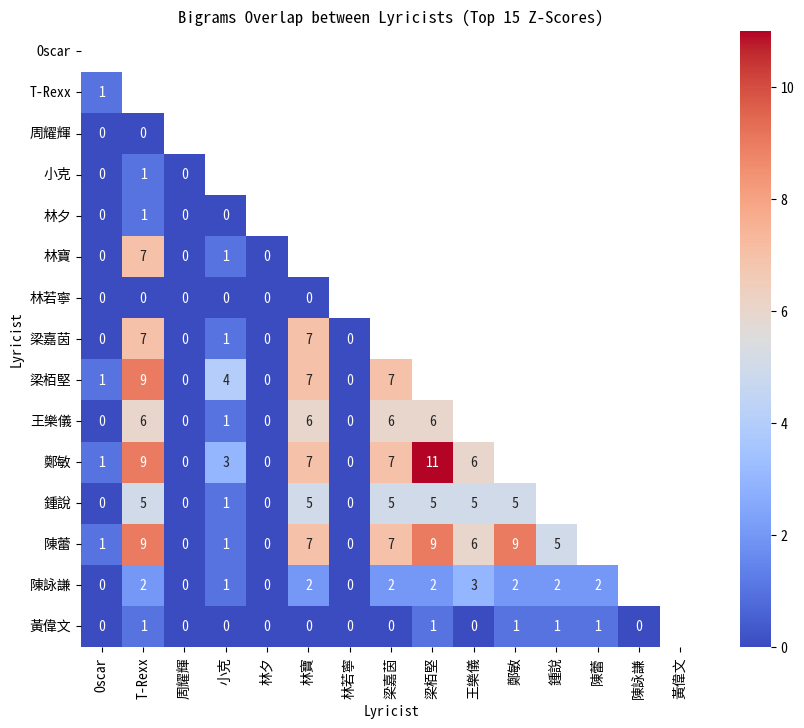

In [214]:
# Plot the heatmap of bigram overlap between lyricists
plt.figure(figsize=(10, 8))
similarity_numeric_df = similarity_zscorerank_df.apply(pd.to_numeric)
mask = np.triu(np.ones_like(similarity_numeric_df, dtype=bool))
sns.heatmap(similarity_numeric_df, mask=mask, annot=True, cmap='coolwarm', fmt='g')
plt.title('Bigrams Overlap between Lyricists (Top 15 Z-Scores)')
plt.xlabel('Lyricist')
plt.ylabel('Lyricist')
plt.show()

#### Correlation between semantic and collocation similarity?
A score of -.33 was got when comparing two matrices, suggesting that even though some lyricists used similar words, their collocation patterns still differed.

In [257]:
from scipy.stats import pearsonr, spearmanr

# make df to numpy array, and then latten both arrays into 1D array, and ensure data type as float
embedding_similarity_flattened = emb_similarity_df.to_numpy()[np.tril_indices_from(emb_similarity_df, k=-1)].astype(float)
collocation_similarity_flattend = similarity_zscorerank_df.to_numpy()[np.tril_indices_from(similarity_zscorerank_df, k=-1)].astype(float)
pearson_corr, _ = pearsonr(embedding_similarity_flattened, collocation_similarity_flattend)
print(f"Pearson-correlation score between word embedding and collocation z-score: {pearson_corr:.2f}")


Pearson-correlation score between word embedding and collocation z-score: -0.33


#### Going back to embeddings - song embedding
An attempt was made to aggregate the embeddings of all tokens in a song, for each lyricist, then see if there was/were particular cluster(s) of lyricist(s). The PCA diagram showed no significant cluster of any lyricists.

In [216]:
song_embeddings = []

for _, row in grand_df_in_top15.iterrows():
    lyricist = row['Lyricist']
    tokenized = row['tokenized'] # list of list of tokenised word
    embs_list = []
    for sent in tokenized:
        for word in sent:
            token = nlp(word)
            if token.has_vector:
                embs_list.append(token.vector)

    if embs_list:
        song_emb = np.mean(embs_list, axis=0)
    else:
        song_emb = np.zero(nlp_model.vocab.vectors_length)
    
    # Append the lyricist and the song embedding to the list
    song_embeddings.append((lyricist, song_emb))

# Convert the list of embeddings into a DataFrame for clustering
df_embeddings = pd.DataFrame(song_embeddings, columns=['Lyricist', 'Embedding'])


In [217]:
df_embeddings

Lyricist                                          Embedding
0        黃偉文  [-0.68708515, 1.0408722, 0.5523957, -1.2795941...
1        林若寧  [-1.4472123, 1.9368491, 0.54778993, -1.0928977...
2        林若寧  [-1.024475, 1.8770583, 0.806686, -0.8582403, 1...
3        黃偉文  [-0.6480897, 1.3262849, 0.27336884, -1.0455561...
4        黃偉文  [-1.1439621, 0.94869596, 0.31009823, -0.933924...
..       ...                                                ...
405       林夕  [-0.4195377, 1.6784582, 0.08921304, -0.8935596...
406       鍾說  [-1.0908923, 1.2324996, 0.44559932, -1.0472068...
407       鍾說  [-1.082707, 0.40776893, 0.17474791, -1.1450263...
408      林若寧  [-1.0064976, 1.0562433, 0.4499432, -1.5253491,...
409      黃偉文  [-0.41452953, 0.98199475, 0.19955845, -0.99701...

[410 rows x 2 columns]

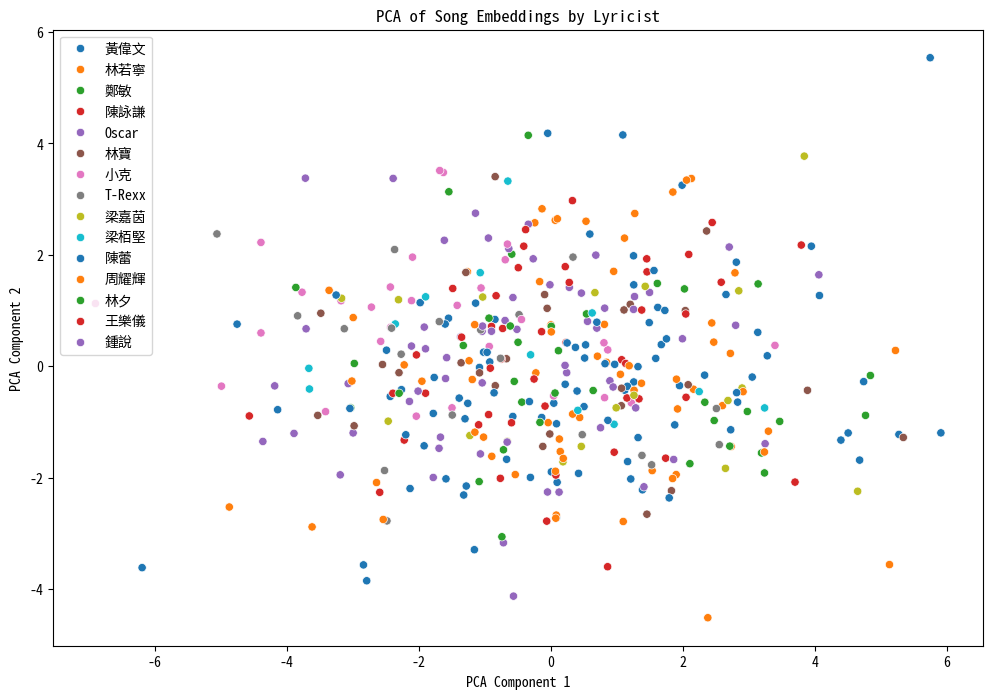

In [219]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the song embeddings (as a matrix)
X = np.vstack(df_embeddings['Embedding'].values)

# Apply PCA to reduce the embeddings to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add the reduced dimensions to the DataFrame for visualization
df_embeddings['PCA1'] = X_pca[:, 0]
df_embeddings['PCA2'] = X_pca[:, 1]

# View the DataFrame
# print(df_embeddings.head())

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Lyricist', data=df_embeddings, palette='tab10')

# Add plot labels
plt.title('PCA of Song Embeddings by Lyricist')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.legend(loc='best')
plt.show()

### Limitations
This exploratory study attempted too find out semantic and collocation difference among lyricists. Ultimately, it not successfully reveal any significant cluster or correlation between any pair of lyricists. One interpretation can be that lyricists actually differ a lot in terms of word semantics collocations. However, it must be recognised that the study has been greatly limited by the following factors:  
1. Inadequate data: Currently there are no well-curated database of Cantonese songs lyrics. Online resources are scattered and oftern requires significant effort of data cleaning. The current database only consists of 600 songs, which are suboptimal. If more data were available, the results would have been more meaningful.
2. Text genre: Song lyrics are usally split into multiple lines with no consistent manner. For example, in one song lyrics are split based song melody and rythm, whereas in another song lyrics are split on literal sentence level. For ease of processing in the project, a simple "brute-force" split by "/n" was used, therefore it might have missed a number of meaningful sentences.  
3. Inadequate NLP tools for Cantonese: Cantonese is still "less-resourced" in NLP field, resulting in lower accuracy in POS tagging. One prominent deficiency was reflected in the bigram collocated with 未來(future). 未來 was more often parsed as 未 (not yet ADV) -來 (come VERB) and thus missed during the search. The current results were not significant enough.

### Conclusion and Future Work
This project has attempted to investigate linguistic difference in Cantopop songs in terms of semantic and syntactic features. Semantically speaking 鍾說, 梁嘉茵, and T-Rexx are more different than the other lyricists. In terms of collocations, it was found that most lyricists have their own preference of collocations. For furture further works, if more data would be available, building lyricist profiles might be a good way to comprehensively assess each lyricist's style or thematic focus.

In [269]:
##################
# testing
##################

# statistics over the number of lyrics by different lyricists by years
# group by year and lyricist and count the number of songs
lyricist_counts_by_year = grand_df_in_top15.groupby(['year', 'Lyricist']).size().reset_index(name='number_of_songs')

# Step 3: Pivot the data to see which lyricists are missing in certain years
pivot_data = lyricist_counts_by_year.pivot(index='year', columns='Lyricist', values='number_of_songs')

# Step 4: Fill missing values with 0
pivot_data_filled_with_0 = pivot_data.fillna(0)

# Step 5: Stack the pivoted data back into long form
stacked_data = pivot_data_filled_with_0.stack().reset_index(name='num_of_songs')

# Extra: count the top 3 of each year
lyricist_counts_by_year = lyricist_counts_by_year.sort_values(by=['year', 'number_of_songs'], ascending=[True, False])
top_3_lyricists_per_year = lyricist_counts_by_year.groupby('year').head(3).reset_index(drop=True)


## tf-idf
option 1: tokenize all texts, pick out the most frequent 500 words
- challenge: rely on countVectorize 內置 tokenizer so cannot remove those "non-frequent" / "unimportant" words simply
- possible: make a stopword list to remove those "unimportant" 

option 2: directly brute force tokenize every lyrics text (no pre-select frequent words)

## TODO
create a list of stopwords:
- words that have certain prefix, which usually produce function (compound) words
- the creation will reference all the tokenised lyrics and append the stopword candidates

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

"""
Generate a stopword list to reduce the unimpportant words for CountVectorizer (tf-idf)
"""

def generate_stopwords(tokens_corpus):
    stopwords_candidate = []
    for token_list in tokens_corpus:
        for token_sent in token_list:
            for token in token_sent:
                if len(token) == 1: # bring all monosyllable token to stopwords list
                    if token not in stopwords_candidate:
                        stopwords_candidate.append(token)
                    continue
                else:
                    # bring all tokens with the following frequent functional prefixes to stopwords list
                    removables = ["一", "不", "這", "那", "沒", "何", "上", "下", "二", "兩", "三", "四", "五", "六", "七", "八", "九", "十", "各", "哪", "我", "你", "他", "之", "也", "太", "前", "後", "仍", "還", "其", "幾", "甚", "什", "更", "有", "以", "自", "要", "繼", "能", "從", "每", "可", "只", "但", "如", "今", "明"]
                    if token[:1] in removables:
                        if token not in stopwords_candidate:
                            stopwords_candidate.append(token)
                
    return stopwords_candidate


"""
take all lyrics in the corpus and create a tf-idf matrix for all songs

"""
def create_tfidf_matrix(lyrics_corpus):
    stopwords = ["一","一些", "一個","一出","一分","一切","一刻","一千里","一口氣","一句","一天","一套","一家","一對","一崩水","一張","一扇","一批","一支","一本","一朵","一樣","一欄","一次","一片","一班","一生一世","一番","一眼","一章","一筆","一等","一粒","一續","一般"]
    try:
        stopwords = generate_stopwords(lyrics_corpus['tokenized'])
        print(stopwords)
        lyrics_texts = lyrics_corpus['lyrics']
    except Exception as e:
        print(e)
    lyrics_astexts = []
    for lyrics in lyrics_texts:
        combined = "，".join(lyrics)
        print(combined)
        lyrics_astexts.append(combined)
    print(lyrics_astexts)
    count_vectorizer = CountVectorizer(stop_words=stopwords, tokenizer=cantoseg.cut)
    X = count_vectorizer.fit_transform(lyrics_astexts)
    return pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names_out())

# tfidf_first100 = create_tfidf_matrix(grand_df.iloc[0:100])

# test = ['連環錯愛，有誰夠我不幸，被留在地雷陣覓熱吻，但求是沒遺憾盡人事做做，怕餘生良心會斥責我從未陪襯，但崩壞的命盤，樣樣亦太一般，無一欄可自滿，全心厚待你仍然功倍但事半，就是耐性最好的亦嫌我悶，夢想越想越悲觀，誰曾如獲至寶千金也不換，明明並不圓滿然而弱小塵蟎怎麼敢談判，熱情未被承認但仍舊自命有團火，如果老天有眼派你來扶起我，但崩壞的命盤，樣樣亦太一般，無一欄可自滿，全心厚待你仍然功倍但事半，就是耐性最好的亦嫌我悶，夢想越想越悲觀，誰曾如獲至寶千金也不換，明明並不圓滿然而弱小塵蟎怎麼敢談判，漂亮過燦爛過你或會喜歡我悶，八十歲到病榻相伴我也算是笑著蓋棺，越找越不樂觀，但現在已不管，情願調整自我觀茶杯未滿，仍然裝著大半盡力做我這手牌若無法換，别誇大這份悲觀，連環無盡錯戀教我學會心寬，今年錯了大半明年或者圓滿，終生都圓滿安心等誰接管', '仍然裝著大半盡力做我這手牌若無法換，别誇大這份悲觀，連環無盡錯戀教我學會心寬']
# # count_vectorizer = CountVectorizer(stop_words=stopwords, tokenizer=cantoseg.cut)
# count_vectorizer = CountVectorizer(tokenizer=cantoseg.cut)
# X = count_vectorizer.fit_transform(test)



In [322]:
######
## tf-idf version 1
######

# tfidf_first100

/Users/kellyyip/Downloads/datascience/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/kellyyip/Downloads/datascience/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['互數', '侵', '匆', '室', '崩水', '忠', '恭', '鍋', '雅'] not in stop_words.
  warnings.warn(


tfidf_vectorizer.get_feature_names_out() result: 
['世上' '世界' '世間' '了解' '人人' '人們' '人生' '人間' '人類' '任性' '伴侶' '來日' '假使' '偏偏'
 '偶爾' '傷口' '優雅' '光陰' '再多' '再見' '出生' '出走' '分享' '分開' '別人' '到底' '到處' '剎那'
 '剩下' '努力' '勇敢' '勇氣' '動人' '原地' '原諒' '反應' '吸引' '呼吸' '命運' '唯有' '唯獨' '問題'
 '喜歡' '單身' '回憶' '回望' '回頭' '地球' '大概' '天地' '天天' '天生' '天真' '天空' '失去' '失戀'
 '好好' '好過' '妄想' '始終' '存在' '孤單' '學會' '宇宙' '安好' '完美' '害怕' '寂寞' '寧願' '尋找'
 '對抗' '已經' '希望' '平凡' '幸福' '幻想' '彷彿' '彼此' '很多' '得到' '心中' '心裡' '心跳' '忘掉'
 '忘記' '快樂' '怎會' '思想' '恐怖' '情人' '情感' '情緒' '情願' '惡夢' '想到' '想要' '想起' '愉快'
 '意義' '愛情' '感情' '感激' '感覺' '慢慢' '懂得' '懷疑' '戀愛' '成就' '成為' '成長' '或是' '或者'
 '找到' '承受' '抱緊' '抱著' '拯救' '拼命' '捉緊' '掙扎' '掛念' '接受' '擁抱' '擁有' '擔心' '改變'
 '放下' '放任' '放低' '放手' '放棄' '放肆' '放開' '故事' '散落' '方向' '旁人' '是否' '時代' '時候'
 '時光' '時間' '曾經' '最初' '最好' '最愛' '最終' '期待' '期望' '未來' '未夠' '未能' '根本' '欣賞'
 '正常' '此刻' '歲月' '比較' '永遠' '決定' '沉默' '沿路' '活著' '浪漫' '消失' '混亂' '清楚' '渴望'
 '渺小' '溫暖' '溫柔' '溫馨' '滿足' '漆黑' '漸漸' '無力' '無奈' '無從' '無懼' '無法' '無聊' '無論'
 '無謂' '無限' '然後' '煙花' '熱吻' '

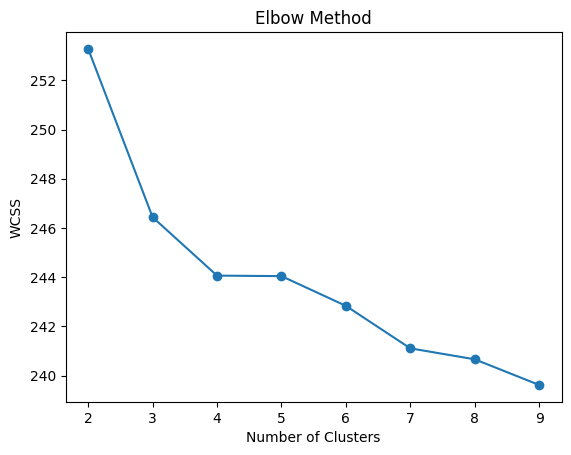

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

"""
create a tfidf matrix using TfidfVectorizer or (if kmeans = True0) cluster the vectors.

parameter:
lyrics_tokenized: the column that contains lists of tokenised lyrics
lyrics_texts: the column that contains list of original lyrics texts
kmeans: whether clustering is needed

"""
def create_tfidf_matrix_v2(lyrics_tokenized, lyrics_texts, kmeans = False):
    # preset a list of stopwords
    stopwords = ["為何", "可以", "怎麼", "怎樣", "然而", "假如", "除了", "除非", "最後", "終於", "多麼", "多少", "所以", "所有", "即使", "監製", "編曲", "無人", "為了", "因為","尚有", "就是", "就算", "難道", "假如", "必須", "原來", "唯求", "早已", "可能", "全部", "應該"]
    try:
        additional_stopwords = generate_stopwords(lyrics_tokenized) # extract additional stopwords to the preset one
        for item in additional_stopwords:
            if item not in stopwords:
                stopwords.append(item)
    except Exception as e:
        print(e)
    lyrics_astexts = []

    for lyrics in lyrics_texts:
        combined = "，".join(lyrics)
        lyrics_astexts.append(combined)

    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, tokenizer=cantoseg.cut, use_idf=True, max_features=300)
    X = tfidf_vectorizer.fit_transform(lyrics_astexts)
    result = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    print("tfidf_vectorizer.get_feature_names_out() result: ")
    print(tfidf_vectorizer.get_feature_names_out())
    
    if kmeans is False:
        print("returned the dataframe from tdidfVectorizer")
        return result
    else:
        print("print the dataframe from tdidfVectorizer: ")
        print(result)

        # use elbow method to determine the "breaking point" of the variance of different number clustering
        wcss = []

        for i in range(2, 10):
            km = KMeans(n_clusters=i, random_state=42)
            km.fit(result)
            wcss.append(km.inertia_)

        plt.plot(range(2, 10), wcss, marker='o')
        plt.title('Elbow Method')
        plt.xlabel('Number of Clusters')
        plt.ylabel('WCSS')
        plt.show()

        ##################
        ##################
        ##################
        #
        # after determining the number
        # continue with the clustering
        #
        ##################
        ##################
        ##################
        ##################

        # # kmean clustering
        # number_of_clusters = 2
        # km = KMeans(n_clusters=number_of_clusters)
        # km.fit(result)
        # clusters = km.labels_

        # # use PCA to carry out a Dimensionality Reduction for better visualisation
        # pca = PCA(n_components=2)
        # reduced_data = pca.fit_transform(result)

        # # Plot the clusters
        # plt.figure(figsize=(10, 6))
        # scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="tab10", s=50)
        # plt.title('KMeans Clustering of Lyrics Data (PCA reduced)')
        # plt.xlabel('PCA Component 1')
        # plt.ylabel('PCA Component 2')
        # plt.colorbar(scatter)
        # plt.show()

        # # retrieve the top terms per cluster
        # print("Top terms per cluster:")
        # order_centroids = km.cluster_centers_.argsort()[:, ::-1]
        # terms = tfidf_vectorizer.get_feature_names_out()
        # for i in range(number_of_clusters):
        #     top_words = [terms[index] for index in order_centroids[i, :4]]
        #     print("Cluster {}: {}".format(i, ' '.join(top_words)))

create_tfidf_matrix_v2(grand_df['tokenized'], grand_df['lyrics'], kmeans=True)

In [ ]:
pd.set_option('display.max_rows', 100)


In [ ]:
Y = grand_df.groupby(by="Lyricist").size().reset_index(name='counts').sort_values(by="counts",ascending=False)
for index, row in Y.iterrows():
    if row["counts"] > 5:
        print(row["Lyricist"], row["counts"])


黃偉文 98
Oscar 56
林若寧 45
小克 36
陳詠謙 34
林夕 32
周耀輝 31
林寶 30
T-Rexx 23
陳蕾 22
王樂儀 20
梁栢堅 14
Serrini 14
鍾說 14
鄭敏 9
林家謙 7
梁嘉茵 7
藍奕邦 6
陳耀森 6
Tim Lui 6


In [ ]:
# set pandas show how many rows to display
# pandas.set_option('display.max_rows', 10)
# pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)
# grand_df['lyrics']